# 链接仪器

In [2]:
from qulab.sugar import connect
from qulab.job import Job
from qulab.storage.utils import save
import matplotlib.pyplot as plt, seaborn as sns
import numpy as np, sympy as sy, visa
from collections import namedtuple, deque, defaultdict, OrderedDict, Counter
from scipy.optimize import curve_fit, least_squares as ls
import time, asyncio, sys, imp, pandas as pd
from tqdm import tqdm_notebook as tqdm
from easydl import clear_output
from sklearn.cluster import KMeans
from configparser import ConfigParser
from qulab import optimize, measureroutine_wave, computewave_wave, imatrix, waveform_new, measureroutine, computewave
# from qulab.waveform import CosPulseDrag, Expi, DC, Step, Gaussian
from qulab.math.qst import transformList, acquireVFromData, vToRho
from qulab.math import opt
opt = imp.reload(opt)
op = imp.reload(optimize)
mrw = imp.reload(measureroutine_wave)
cww = imp.reload(computewave_wave)
mx = imp.reload(imatrix)
wn = imp.reload(waveform_new)
# mr = imp.reload(measureroutine)
# cw = imp.reload(computewave)
# mn = imp.reload(measureroutine_new)
# wf = imp.reload(wavepoint)

In [3]:
awg131 = await connect('AWG131')
awg132 = await connect('AWG132')
awg133 = await connect('AWG133')
awg134 = await connect('AWG134')
afg= await connect('AFG')
awg100 = await connect('AWG100')
ats18 = await connect('ATS18')
# ats19 = await connect('ATS19')
psg101 = await connect('PSG101')
psg230 = await connect('PSG230')
# psg104 = await connect('PSG104')
# psg103 = await connect('PSG103')
psg105 = await connect('PSG105')
psg106 = await connect('PSG106')
dc01 = await connect('DC01')
dc02 = await connect('DC02')
dc03 = await connect('DC03')
dc04 = await connect('DC04')
dc05 = await connect('DC05')
dc06 = await connect('DC06')
dc07 = await connect('DC07')
dc08 = await connect('DC08')
dc10 = await connect('DC10')
dc11 = await connect('DC11')
dc15 = await connect('DC15')
dc20 = await connect('DC20')
afg = await connect('AFG')
# att3 = await connect('Att3')
# att4 = await connect('Att4')
# att5 = await connect('Att5')
# att6 = await connect('Att6')
# att7 = await connect('Att7')
# att8 = await connect('Att8')
# att9 = await connect('Att9')
# # #pna = await connect('PNA')

In [352]:
await awg133.query('*IDN?')

'TEKTRONIX,AWG5208,B010153,FV:6.1.0054.0\n'

# redis测试

In [75]:
import redis

# 普通连接
conn = redis.Redis(host="10.122.7.20",port=6379)
conn.set("x1","hello",ex=1) # ex代表seconds，px代表ms
val = conn.get("x1")
print(val)

b'hello'


# 设置TrigB

In [4]:
await afg.reset()
await asyncio.sleep(2)
await afg.setValue('Output','ON',ch=1)
await afg.setValue('Function','Pulse',ch=1)
await afg.setValue('Pulse Period',110e-6,ch=1)
await afg.setValue('Pulse Width',1e-6,ch=1)
await afg.setValue('Amplitude',5,ch=1)
await afg.setValue('Offset',0,ch=1)

In [6]:
for i in range(20):
    await afg.write('*TRG')
    time.sleep(1)

# qubit工作点

In [4]:
# freqall = np.array([6.505,6.517,6.53,6.542,6.559,6.571,6.587,6.601,6.6045,6.63])*1e9
# freqall = np.array([6.451,6.466,6.478,6.494,6.51,6.508,6.516,6.534,6.563,6.576])*1e9
freqall = np.array([6.545, 6.564, 6.588, 6.608, 6.63, 6.642, 6.649, 6.689, 6.71, 6.73])*1e9
# freqall = freqall[::-1]
f_cavity = {'q%d'%(i):j for i, j in enumerate(freqall,start=1)}

In [113]:
measure.jpa = jpa

In [6]:
jpa = mrw.qubit(q_name='jpa',inst={'dc':'dc15','pump':'psg_pump'},bias=-1.426,f_ex=2*6.75e9+2e6,power_ex=5.78) #power=-2.1

In [5]:
jpa = mrw.qubit(q_name='jpa',inst={'dc':'dc15','pump':'psg_pump'},bias=-1.465,f_ex=2*6.75e9+2e6,power_ex=5.42)

## 保存工作点

In [26]:
qstate = []
def tuple2dict(q):
    for i in q:
        qstate.append(i.asdict())
    return qstate

bit = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
filepath = save('QubitState','qubitstate',state = tuple2dict(bit),base_path=r'D:\skzhao\file_name\wave')
with open(r'D:\skzhao\file_name\qubit_state_wave.txt', mode='a') as filename:
    filename.write(str(filepath))
    filename.write('\n')
print(filepath)

D:\skzhao\file_name\wave\2020\1004\QubitState\qubitstate_20201004155358.npz


In [41]:
q1.T_bias

[2.58, -0.038]

## 提取工作点

In [6]:
fl = np.loadtxt(r'D:\skzhao\file_name\qubit_state_wave.txt',dtype='str')
f = str(fl[-1])
data = np.load(f,allow_pickle=True)
def dict2tuple(q):
    for i,k in enumerate(q):
        attr = {}
        for j in mrw.qubit().asdict():
            if j in k:
                attr[j] = k[j]
            else:
                attr[j] = None
        globals()[k['q_name']] = mrw.qubit(**attr)

dict2tuple(data['state'])
print(f)


D:\skzhao\file_name\wave\2020\1004\QubitState\qubitstate_20201004155358.npz


In [6]:
qubitlist = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
measure.qubits= {i.q_name:i for i in qubitlist}

NameError: name 'measure' is not defined

# 提取IQ-Mixer配置参数

In [6]:
fl = np.loadtxt(r'D:\skzhao\file_name\iqmixer_state.txt',dtype='str')
f = str(fl[-1])
data = np.load(f,allow_pickle=True)

atributte = ['q_name','alpha_read','alpha_ch1','alpha_ch2','alpha_ch3','alpha_ch4','alpha_ch5',\
            'beta_read','beta_ch1','beta_ch2','beta_ch3','beta_ch4','beta_ch5']
Iqmixer = namedtuple('Iqmixer',atributte,defaults=[{} for i in range(12)])

iqm = Iqmixer(q_name='Iqm') #power=-2.1

def dict2tuple(q):
    global iqm
    for i,k in enumerate(q):
        attr = []
        for j in atributte:
            if j in k:
                attr.append(k[j])
            else:
                attr.append(None)
        iqm = Iqmixer(*attr)

dict2tuple(data['state'])
# print(f,iqm)

In [7]:
iqm.alpha_read

{}

In [414]:
ch_I, ch_Q, offset_I, offset_Q = 5,6,-3.700e-02, -5.000e-02
awg = awg132
await awg.setValue('Offset',offset_I,ch=ch_I)
await awg.setValue('Offset',offset_Q,ch=ch_Q)

## 保存提取全局变量

In [433]:
cw.saveStatus(fname='D:/status.obj')

In [5]:
cw.loadStatus(fname='D:/status.obj')

# 指定仪器

In [7]:
psg_lo = psg105
psg_ex1 = psg106
psg_trans = psg230
# psg_ex2 = psg106
# psg_ex3 = psg103
psg_pump = psg101
psg = {'psg_lo':psg_lo,'psg_ex1':psg_ex1,'psg_trans':psg_trans,'psg_pump':psg_pump}
ats = ats18
dc = {'q8':dc01,'q6':dc02,'q3':dc11,'q5':dc03,'q4':dc08,\
      'q9':dc07,'q2':dc10,'q7':dc06,'jpa':dc15,'q10':dc05,'q1':dc20}
#awg = awg132
# attinst = {'com3':att3,'com4':att4,'com5':att5,'com6':att6,'com7':att7,'com8':att8,'com9':att9}
attinst={}
awg_list = {'awg131':awg131,'awg132':awg132,'awg133':awg133,'awg134':awg134,'awgread':awg133,'awg_trig':awg133}

In [33]:
measure.psg = psg

In [15]:
measure.dc = dc

## 测量类

In [8]:
measure = mrw.common(f_cavity,ats,dc,psg,awg_list,attinst,jpa,[q1,q2,q3,q4,q5,q6,q7,q8,q9,q10])

# 初始化及同步AWG

In [9]:
await mrw.resetAwg(awg_list)

In [8]:
await mrw.awgSync(measure)

In [94]:
with open(r'D:\QuLabData\awgGui\state.txt', mode='w') as filename:
    filename.write('[5,0,75,65]')
    filename.write('\n') 

In [56]:
x = np.loadtxt(r'D:\QuLabData\awgGui\state.txt',delimiter=',',dtype=str)

# 信号检查

In [11]:
# delta = np.array([1.75e+08, 1.62e+08, 1.49e+08, 1.36e+08, 1.21e+08, 1.07e+08,
#        9.30e+07, 8.00e+07, 7.50e+07, 5.00e+07])
# f_lo, delta, n = await mr.resn(f)
# delta = measure.delta
delta = np.array([20e6])
await cww.modulation_read(measure,delta,readlen=1500)
# await mr.ats_setup(ats,delta,l=180+128)
await awg133.run()
f_list = await ats.getValue('f_list')
f_list

array([20000000.])

## 读出信号相位噪声

Output()

<IPython.core.display.Javascript object>


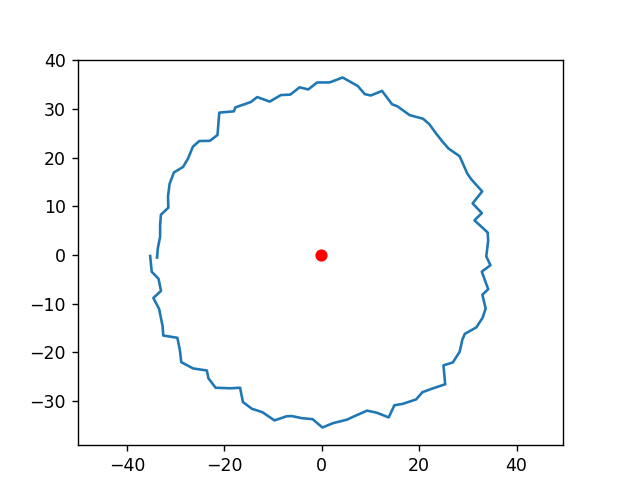

In [136]:
phase = np.linspace(0,2*np.pi,101)
job = Job(mr.rPhase, (measure,phase), tags=['phase noise'], max=len(phase))
pp, sp = await job.done()
plt.figure(figsize=(5,4))
plt.plot(np.real(sp[:,0]),np.imag(sp[:,0]))
plt.plot(np.mean(np.real(sp[:,0])),np.mean(np.imag(sp[:,0])),'ro')
plt.axis('equal')
plt.show()

In [34]:
f_list = await ats.setValue('repeats',201)

In [70]:
f_list = await ats.getValue('f_list')
f_list

array([50000000.])

In [76]:
await psg_lo.setValue('Frequency',6.56e9)

## 复平面信号

<IPython.core.display.Javascript object>


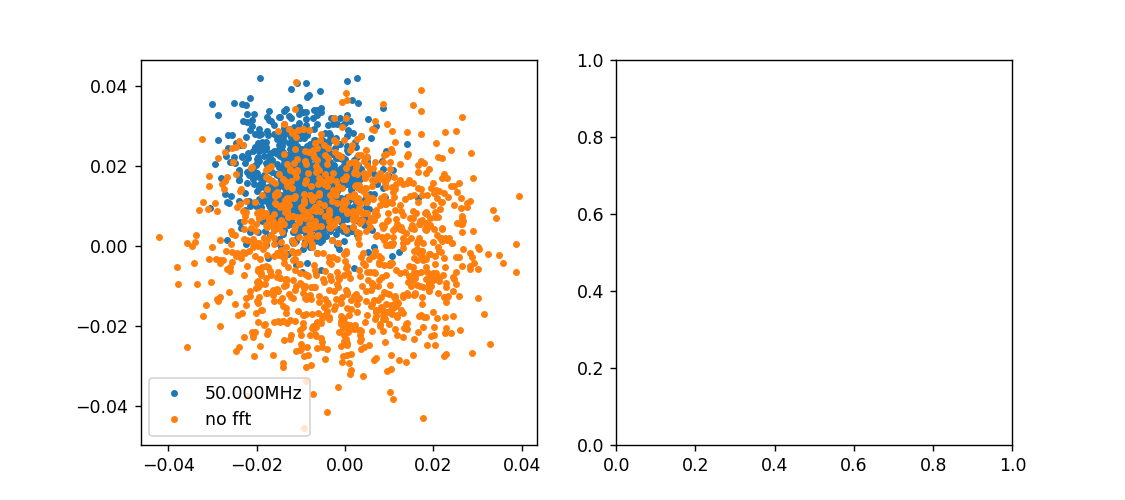

In [250]:

I, Q = 0, 0
await psg_lo.setValue('Output','ON')
await psg_ex1.setValue('Output','OFF')
await mr.jpa_switch(measure,state='OFF')
f_list = np.array(await ats.getValue('f_list'))
for i in range(1):
    chA, chB, ch_I, ch_Q = await ats.getTraces(fft=False,avg=True,hilbert=True,is2ch=False,offset=True)
    I += chA
    Q += chB
s, e, h = (I+1j*Q), [], len(f_list)//2+len(f_list)%2
t = np.arange(0, len(s), 1) / 1e9

fig, axes = plt.subplots(ncols=2,nrows=h,figsize=(9,4*h))
for i,f in enumerate(f_list):
    em = np.exp(-1j * 2 * np.pi * f * t)
    e.append(em)
    if h == 1:
        axes[i].plot(np.real(s*em),np.imag(s*em),'.',label='%.3fMHz'%(f/1e6))
        axes[i].plot(np.real(s),np.imag(s),'.',label='no fft')
        axes[i].legend(loc="lower left")
    else:
        axes[i//2][i%2].plot(np.real(s*em),np.imag(s*em),'.',label='%.3fMHz'%(f/1e6))
        axes[i//2][i%2].plot(np.real(s),np.imag(s),'.',label='no fft')
        axes[i//2][i%2].legend(loc="lower left")

plt.show()

## 时域信号

<IPython.core.display.Javascript object>


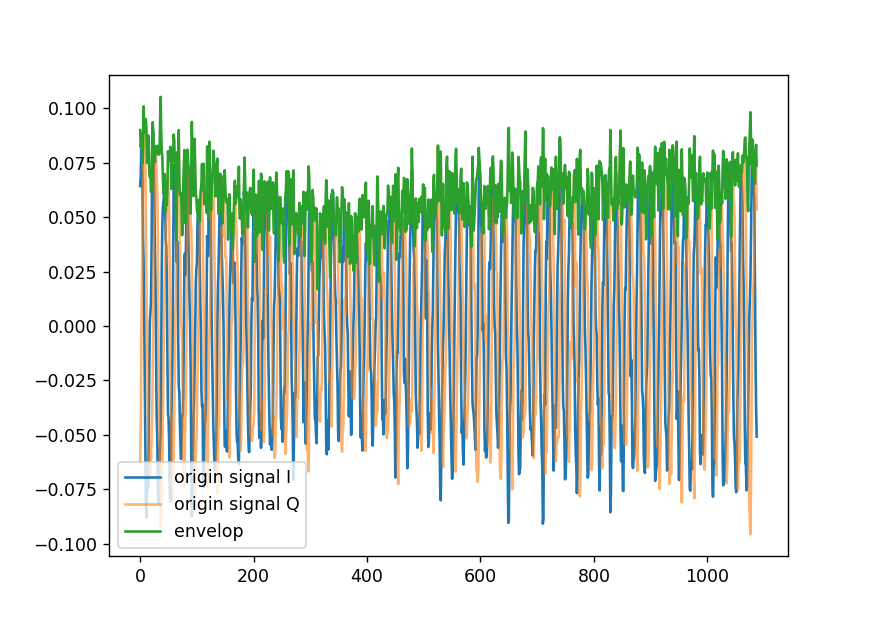

In [22]:
%matplotlib notebook
I, Q = 0, 0
await psg['psg_lo'].setValue('Output','ON')
await psg['psg_ex1'].setValue('Output','OFF')
for i in range(1):
    chA, chB, ch_I, ch_Q = await ats.getTraces(hilbert=False,is2ch=False)
    I += chA
    Q += chB
    
plt.figure(figsize=(7,5))
plt.plot(np.arange(len(I)), I,label='origin signal I')
plt.plot(np.arange(len(Q)), Q,label='origin signal Q',alpha=0.6)
plt.plot(np.arange(len(Q)), np.sqrt(I**2+Q**2),label='envelop')
plt.legend(loc="lower left")
plt.show()

In [182]:
await psg_lo.setValue('Frequency',5e9)

## 频域信号

<IPython.core.display.Javascript object>


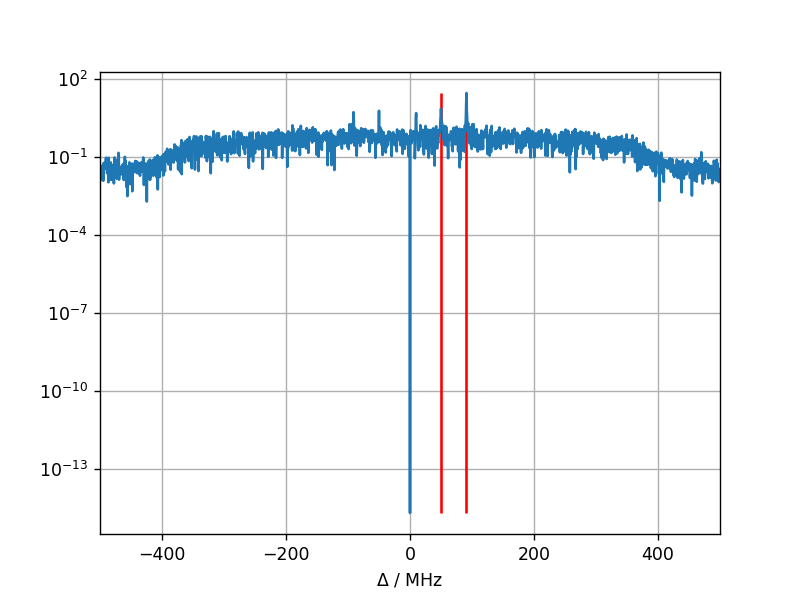

In [951]:
f = np.fft.fftshift(np.fft.fftfreq(len(I)))*1e9
Pxx = np.abs(np.fft.fftshift(np.fft.fft(I + 1j*Q)))
# x, y = np.linspace(0,len(I),len(I))*1e-9, I + 1j*Q
# f, Pxx = op.RowToRipe().spectrum(x,y,method='welch',shift=True)
Delta_list = np.array(await ats.getValue('f_list'))
plt.figure()

plt.vlines(Delta_list/1e6, np.min(Pxx), np.max(Pxx), 'r')

plt.semilogy(f/1e6, Pxx)

plt.grid(which='both')
plt.xlabel(r'$\Delta$ / MHz')
plt.xlim(-500,500)
plt.show()

In [247]:
y

3

# 仪器状态

In [10]:
clearseq = [f'awg13{i+1}' for i in range(4)]
clearseq = []
await mrw.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=clearseq)

In [186]:
state = await mrw.QueryInst(measure)
pd.DataFrame(state)

q8      q6      q3      q5      q4      q9      q2      q7  \
ch1         NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ch2         NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ch3         NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ch4         NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ch5         NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ch6         NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ch7         NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ch8         NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
error        +0      +0      +0      +0      +0      +0      +0      +0   
freq        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
load     high Z  high Z  high Z  high Z  high Z  high Z  high Z  high Z   
mform       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
moutput     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
offset   -0.998  -0.677  -0.345  -0.325   -0.37  -0.724  -0.355  -0.322   
output      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
power       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

            jpa     q10  ...        psg_lo      psg_ex1    psg_trans  \
ch1         NaN     NaN  ...           NaN          NaN          NaN   
ch2         NaN     NaN  ...           NaN          NaN          NaN   
ch3         NaN     NaN  ...           NaN          NaN          NaN   
ch4         NaN     NaN  ...           NaN          NaN          NaN   
ch5         NaN     NaN  ...           NaN          NaN          NaN   
ch6         NaN     NaN  ...           NaN          NaN          NaN   
ch7         NaN     NaN  ...           NaN          NaN          NaN   
ch8         NaN     NaN  ...           NaN          NaN          NaN   
error        +0      +0  ...             0            0            0   
freq        NaN     NaN  ...   6.749400GHz  5.163650GHz  5.799000GHz   
load     high Z  high Z  ...           NaN          NaN          NaN   
mform       NaN     NaN  ...           EXT          EXT          EXT   
moutput     NaN     NaN  ...             0            0            1   
offset   -1.465  -0.252  ...           NaN          NaN          NaN   
output      NaN     NaN  ...             1            1            0   
power       NaN     NaN  ...  18.000000dBm  5.000000dBm  0.000000dBm   

             psg_pump awg131 awg132 awg133 awg134 awgread awg_trig  
ch1               NaN    OFF    OFF     ON    OFF      ON       ON  
ch2               NaN    OFF    OFF     ON    OFF      ON       ON  
ch3               NaN    OFF    OFF    OFF    OFF     OFF      OFF  
ch4               NaN    OFF    OFF    OFF    OFF     OFF      OFF  
ch5               NaN    OFF    OFF     ON    OFF      ON       ON  
ch6               NaN    OFF    OFF     ON    OFF      ON       ON  
ch7               NaN    OFF    OFF    OFF    OFF     OFF      OFF  
ch8               NaN    OFF    OFF    OFF    OFF     OFF      OFF  
error               0      0      0   -220   -220    -220     -220  
freq     13.502000GHz    NaN    NaN    NaN    NaN     NaN      NaN  
load              NaN    NaN    NaN    NaN    NaN     NaN      NaN  
mform            EXT2    NaN    NaN    NaN    NaN     NaN      NaN  
moutput             0    NaN    NaN    NaN    NaN     NaN      NaN  
offset            NaN    NaN    NaN    NaN    NaN     NaN      NaN  
output              1    NaN    NaN    NaN    NaN     NaN      NaN  
power     5.420000dBm    NaN    NaN    NaN    NaN     NaN      NaN  

[16 rows x 21 columns]

In [17]:
await mrw.RecoverInst(measure,state)

In [17]:
int(await awg131.query('OUTP%d:STAT?'%1))

0

In [23]:
await psg_ex1.setValue('Moutput','OFF')

In [163]:
await psg_ex1.setValue('Power',15)

In [18]:
await psg_lo.setValue('Frequency',6.5e9)

In [138]:
measure.delta,measure.base,measure.readlen = q10.state[1:]
await mrw.RecoverInst(measure,state=q10.state[0])

In [43]:
for i in range(1000):
    await awg133.query('syst:err?')

In [17]:
for i in dc:
    await dc[i].setValue('Load','High')

# S21

Output()

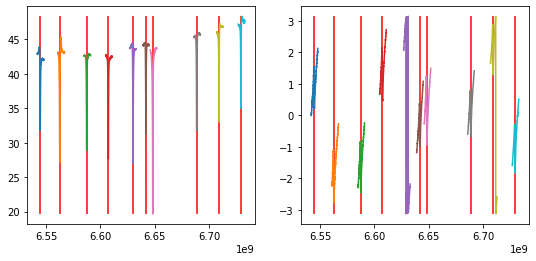

In [246]:
q_target = q1
freq = np.linspace(6,7,1001)*1e9 + 50e6
tag = q_target.q_name
# await measure.attinst['com8'].set_att(38)
await mrw.jpa_switch(measure,state='ON')
# await dc15.DC(-3.398)
f_lo, delta, n, f_res,base,f_s21, s_s21 = await mrw.again(q_target,measure,False,measure.f_lo)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_s21,20*np.log10(np.abs(s_s21)))
axes[0].vlines(f_lo-delta,np.max(20*np.log10(np.abs(s_s21))),np.min(20*np.log10(np.abs(s_s21))),'r')
axes[1].vlines(f_lo-delta,np.max(np.angle(s_s21)),np.min(np.angle(s_s21)),'r')
axes[1].plot(f_s21,np.angle(s_s21))
plt.show()

In [155]:
await att8.query_att()

In [17]:
f_lo-measure.delta

array([6.535e+09])

In [100]:
q10 = q10._replace(f_lo=np.array([6.576e9]))

In [422]:
measure.delta

array([50000000., 90550000., 50200000., 90450000., 90650000., 90700000.,
       50200000., 50050000., 90450000., 50250000.])

In [18]:
await dc10.DC(-0.9)
await dc11.DC(0)

# 读取信号强度随时间变化

Output()

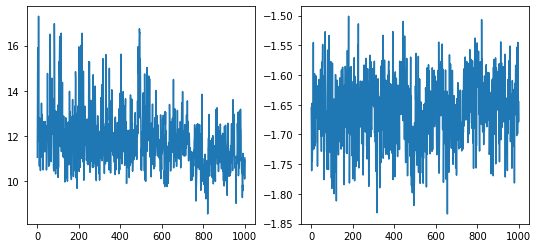

In [28]:
# await measure.attinst['com8'].set_att(20)
await psg_lo.setValue('Output','ON')
# await psg['psg_trans'].setValue('Output','ON')
#await psg[q_target.inst['ex_lo']].setValue('Frequency',f_rabi)
# await mr.jpa_switch(measure,state='OFF')
job = Job(mr.test, (measure,1001), tags=['time varing of signal'], max=1001)
f_s21, s_s21 = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_s21,np.abs(s_s21))
axes[1].plot(f_s21,np.angle(s_s21))
plt.show()

In [96]:
np.mean(np.abs(s_s21))/np.std(s_s21)

10.166608793708301

In [15]:
%matplotlib notebook

# S21vsFlux

In [63]:
bits = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
current = np.linspace(-1,1,21)
measure.readamp = 0.6
# await measure.attinst['com8'].set_att(25)
for i in bits:
    tag = i.q_name
    print(i.inst)
    await mrw.jpa_switch(measure,'ON')
    await psg[i.inst['ex_lo']].setValue('Output','OFF')
    job = Job(mrw.S21vsFlux_awgoffset, (i,measure,current,None), tags=[tag], max=len(current))
    v_bias, f_bias, s_bias = await job.done()
    await mrw.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=None)
    clear_output()

In [17]:
bits = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
current = np.linspace(-2,2,21)
measure.readamp = 0.6
# await measure.attinst['com8'].set_att(25)
for i in bits:
    tag = i.q_name
    print(i.inst)
    await mrw.jpa_switch(measure,'ON')
    await psg[i.inst['ex_lo']].setValue('Output','OFF')
    job = Job(mrw.S21vsFlux, (i,measure,current,None), tags=[tag], max=len(current))
    v_bias, f_bias, s_bias = await job.done()
    await mrw.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=None)
    clear_output()

In [ ]:
calimatrix = np.load(r'D:/QuLabData/2020/0624/crosstalk_cali/q1-q7_20200624171927.npz')['mat']
calimatrix[1:5,1:5]

In [ ]:
calimatrix = np.array([[ 1.        , -0.00614072,  0.00237171,  0.00339285,  0.01229189],
       [ 0.01965284,  1.        , -0.01015246, -0.00295805, -0.00609832],
       [ 0.01144612,  0.02177006,  1.        , -0.01671896, -0.00728347],
       [ 0.01140976,  0.02193547,  0.02581161,  1.        , -0.01872843],
       [ 0.00925843,  0.01711204,  0.01496927,  0.01558848,  1.        ]])

# S21vsPower

In [92]:
qubits = mr.qubitCollections([q1,q2,q3,q4,q5,q6,q7,q8,q9,q10])

Output()

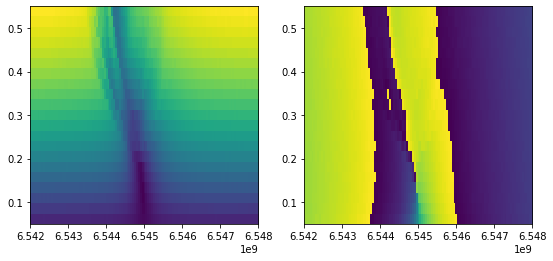

In [15]:
q_target, att = q1, np.linspace(0.05,0.55,21)
tag = q_target.q_name
#await psg[q_target.inst['ex_lo']].setValue('Output','OFF')
job = Job(mrw.S21vsPower, (q_target,measure,att,'com8'), tags=[tag], max=len(att))
att_p, f_p, s_p = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
extent = [np.min(f_p[0][:,0]),np.max(f_p[0][:,0]),np.min(att_p[:,0]),np.max(att_p[:,0])]
axes[0].imshow(np.abs(s_p[:,:,0]),extent=extent,origin='lower',aspect='auto')
axes[1].imshow(np.angle(s_p[:,:,0]),extent=extent,origin='lower',aspect='auto')
plt.show()

# singlespce

In [14]:
calimatrix = np.load(r'D:/QuLabData/2020/0624/crosstalk_cali/q1-q7_20200624171927.npz')['mat']
np.mat(calimatrix)

matrix([[ 1.        ,  0.        ,  0.02081242, -0.00556228, -0.03419392,
          0.0722012 ,  0.07923705,  0.        ,  0.        ,  0.        ],
        [-0.11087751,  1.        ,  0.00911005, -0.03760278, -0.02984445,
          0.07501739,  0.08099287,  0.        ,  0.        ,  0.        ],
        [-0.09237872,  0.        ,  1.        , -0.02808258, -0.03020463,
          0.05719553,  0.07826868,  0.        ,  0.        ,  0.        ],
        [-0.09966487,  0.        ,  0.08454681,  1.        , -0.03020463,
          0.05499408,  0.0763224 ,  0.        ,  0.        ,  0.        ],
        [-0.07804834,  0.        ,  0.07193357, -0.06137783,  1.        ,
          0.0501854 ,  0.07041253,  0.        ,  0.        ,  0.        ],
        [-0.08190848,  0.        ,  0.10309907, -0.06923761,  0.04200055,
          1.        ,  0.08362114,  0.        ,  0.        ,  0.        ],
        [-0.06118311,  0.        ,  0.07212722, -0.06237858,  0.03363237,
         -0.02547738,  1.       

In [20]:
q, bias = q1, 0
q.T_bias
q.T_bias[1]-q.T_bias[0]/2
x = sy.Symbol('x')
f_com = np.float(q.specfunc.evalf(subs={x:bias}))
print(round(f_com,3),q.T_bias,q.T_bias[1]-q.T_bias[0]/2)

4.428 [3.364, -0.229, (3.36212491877869, -0.24)] -1.911


In [61]:
q = q8
q.T_bias[1]-q.T_bias[0]/2

-0.9175

In [13]:
q7.inst

{'z_awg': 'awg132',
 'z_ch': [8],
 'ex_awg': 'awg134',
 'ex_ch': [2, 6],
 'ex_lo': 'psg_ex1',
 'com': 'com3'}

In [24]:
q7.replace(inst={ 'z_awg': 'awg132', 'z_ch': [8], 'ex_awg': 'awg134', 'ex_ch': [2,6], 'ex_lo': 'psg_ex1', 'com': 'com3'},delta_ex=np.array([110e6]))

In [358]:
q10.replace(envelopename=['hanning',2],nwave=1,readamp=0.25,amp=1,shift=0e-9,phase=0,phaseDiff=0,delta_ex=110e6,pi_len=40e-9,\
         seqtype='PDD',detune=3e6,volt=0,offset=0,timing={'z>xy':0e-9,'read>xy':0e-9})

In [236]:
q7.T_bias

[2.652, 0.208]

In [245]:
measure.readamp = 0.5
dcstate = {i: round(measure.qubits[i].T_bias[1]-measure.qubits[i].T_bias[0]/5,3) for i in measure.qubits }
q_target = q1
# att_single, bias = q_target.power_ex, 0.15
#await measure.attinst['com8'].set_att(34)
await mrw.dcManage(measure,dcstate=dcstate,readstate=[],calimatrix=None)

# for i in range(10):
#     q_target = globals()[f'q{i+1}']
#     zname, zch = [f'ch{i}' for i in q_target.inst['z_ch']], q_target.inst['z_ch']
#     await cww.genwaveform(measure.awg[q_target.inst['z_awg']],zname,zch)
#     pulse = await cww.funcarg(cww.zWave,q_target,pi_len=10000/1e9,volt=0,shift=70000/1e9)
#     await cww.writeWave(measure.awg[q_target.inst['z_awg']],zname,pulse,mark=False)
#     await measure.awg[q_target.inst['z_awg']].setValue('Offset',-0.0,ch=zch[0])
#     await cww.couldRun(measure.awg[q_target.inst['z_awg']])


Output()

[(5.32740644761247, 0.8457595932363207)]


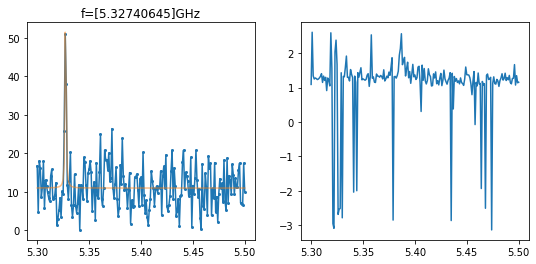

In [238]:
# tag, freq = q_target.q_name, np.arange(-200,201,1)*1e6+round(f_com,3)*1e9
freq = np.arange(5.3,5.5,0.001)*1e9
await psg_trans.setValue('Power',0)
# await measure.attinst['com9'].set_att(30)
# await cw.modulation_ex(q_target,measure)
await mrw.jpa_switch(measure,'ON')
job = Job(mrw.singlespec, (q_target,measure,freq,True,measure.f_lo,True), tags=(measure.qubitToread), max=len(freq))
f_ss, s_ss = await job.done()
state = await mrw.QueryInst(measure)
index = np.abs(s_ss).argmax(axis=0)
x,y,z,band= f_ss/1e9, s_ss,[],[]
for i in range(np.shape(s_ss)[1]):
    try:
        a,b,c,d,e = op.Lorentz_Fit().fitLorentz(x[:,i],np.abs(y[:,i]))
        z.append(a/(1.0+c*(x[:,i]-b)**2)+d)
        band.append((b,e))
    except:
        pass
z = np.array(z).T
f_rabi = np.array([x[:,i][j] for i, j in enumerate(index)])
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(x,np.abs(y),'-o',markersize=2)
axes[0].plot(x,z,alpha=0.5)
axes[0].set_title(f'f={np.array(band)[:,0]}GHz')
print(band)
axes[1].plot(x,np.angle(y))
plt.show()

In [249]:
for i in range(10):
    globals()[f'q{i+1}'].replace(f_ex=np.array(band)[i,0]*1e9,state=[state,measure.delta,measure.base,measure.readlen])

IndexError: index 1 is out of bounds for axis 0 with size 1

In [23]:
%matplotlib notebook

In [25]:
(4.606-4.5)*2

0.21199999999999974

In [250]:
q7.replace(f_ex=5.3274e9,delta_ex=110e6,alpha=212e6,state=[state,measure.delta,measure.base,measure.readlen])
# q9.replace(f_ex=5.3803e9,delta_ex=110e6,alpha=256e6,state=[state,measure.delta,measure.base,measure.readlen])
pd.DataFrame(state)

q8      q6      q3      q5      q4      q9      q2      q7  \
ch1         NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ch2         NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ch3         NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ch4         NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ch5         NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ch6         NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ch7         NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ch8         NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
error        +0      +0      +0      +0      +0      +0      +0      +0   
freq        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
load     high Z  high Z  high Z  high Z  high Z  high Z  high Z  high Z   
mform       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
moutput     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
offset        0       0       0       0       0       0       0   0.208   
output      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
power       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

            jpa     q10  ...        psg_lo      psg_ex1    psg_trans  \
ch1         NaN     NaN  ...           NaN          NaN          NaN   
ch2         NaN     NaN  ...           NaN          NaN          NaN   
ch3         NaN     NaN  ...           NaN          NaN          NaN   
ch4         NaN     NaN  ...           NaN          NaN          NaN   
ch5         NaN     NaN  ...           NaN          NaN          NaN   
ch6         NaN     NaN  ...           NaN          NaN          NaN   
ch7         NaN     NaN  ...           NaN          NaN          NaN   
ch8         NaN     NaN  ...           NaN          NaN          NaN   
error        +0      +0  ...             0            0            0   
freq        NaN     NaN  ...   6.668500GHz  5.505000GHz  5.500000GHz   
load     high Z  high Z  ...           NaN          NaN          NaN   
mform       NaN     NaN  ...           EXT          EXT          EXT   
moutput     NaN     NaN  ...             0            0            1   
offset   -1.465       0  ...           NaN          NaN          NaN   
output      NaN     NaN  ...             1            0            0   
power       NaN     NaN  ...  18.000000dBm  5.000000dBm  0.000000dBm   

             psg_pump awg131 awg132 awg133 awg134 awgread awg_trig  
ch1               NaN    OFF    OFF     ON    OFF      ON       ON  
ch2               NaN    OFF    OFF    OFF    OFF     OFF      OFF  
ch3               NaN    OFF    OFF    OFF    OFF     OFF      OFF  
ch4               NaN    OFF    OFF    OFF    OFF     OFF      OFF  
ch5               NaN    OFF    OFF     ON    OFF      ON       ON  
ch6               NaN    OFF    OFF    OFF    OFF     OFF      OFF  
ch7               NaN    OFF    OFF    OFF    OFF     OFF      OFF  
ch8               NaN    OFF    OFF    OFF    OFF     OFF      OFF  
error               0      0      0   -220   -220    -220     -220  
freq     13.502000GHz    NaN    NaN    NaN    NaN     NaN      NaN  
load              NaN    NaN    NaN    NaN    NaN     NaN      NaN  
mform            EXT2    NaN    NaN    NaN    NaN     NaN      NaN  
moutput             0    NaN    NaN    NaN    NaN     NaN      NaN  
offset            NaN    NaN    NaN    NaN    NaN     NaN      NaN  
output              1    NaN    NaN    NaN    NaN     NaN      NaN  
power     5.420000dBm    NaN    NaN    NaN    NaN     NaN      NaN  

[16 rows x 21 columns]

## 单条谱扫电压

Output()

<IPython.core.display.Javascript object>


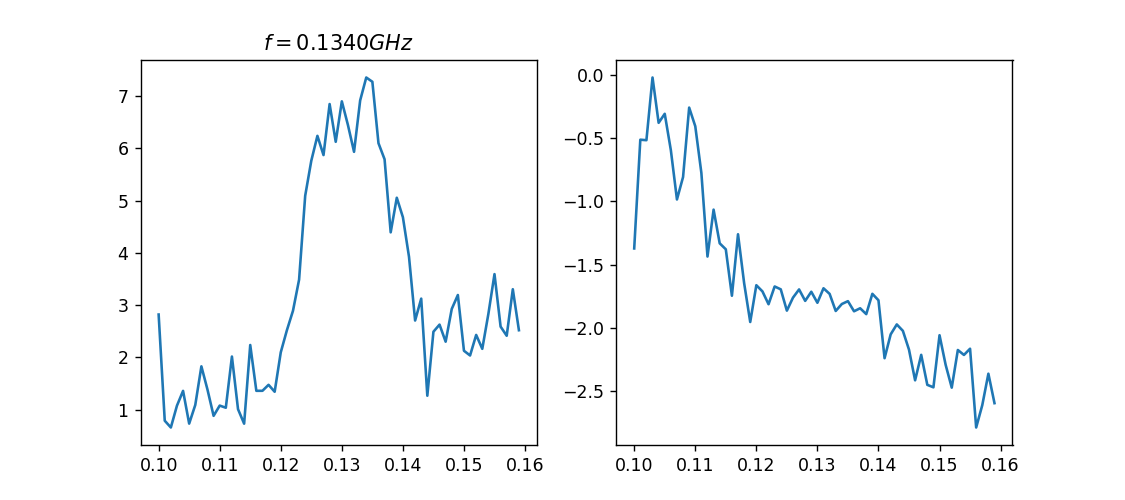

In [135]:
tag, ftarget, biaslist = q_target.q_name, 4.0596e9, np.arange(-0.03,0.03,0.001) + (0.13)

# await psg_trans.setValue('Power',13)
# mr.Att_Setup(measure,'com8').Att(28)
# await cw.modulation_ex(q_target,measure)
# # await psg_ex1.setValue('Moutput','OFF')
# await mr.jpa_switch(measure,'ON')
job = Job(mr.specbias, (q_target,measure,ftarget,biaslist,True), tags=[tag], max=len(biaslist))
v_sb, s_sb = await job.done()
index = np.abs(s_sb).argmax(axis=0)
v_rabi = np.array([v_sb[:,i][j] for i, j in enumerate(index)])
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(v_sb,np.abs(s_sb))
axes[0].set_title('$f=%.4fGHz$'%(v_rabi[0]))
axes[1].plot(v_sb,np.angle(s_sb))
plt.show()

# 功率拉比

In [363]:
q10.replace(envelopename=['hanning',1],nwave=1,amp=1,shift=0e-9,phase=0,phaseDiff=0,delta_ex=110e6,pi_len=15e-9,\
         seqtype='PDD',detune=3e6)

Output()

<IPython.core.display.Javascript object>


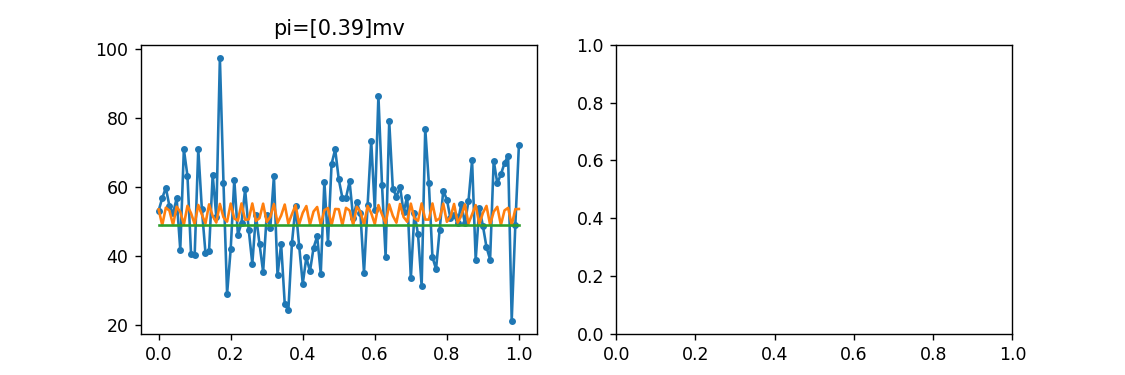

(38.10698048190423, 52.08874944774501, 20000, 31.683168316831683, 0)


In [152]:
q_target = q10
amp = np.linspace(0,1,101)
att_single = 30
tag = q_target.q_name
# await measure.attinst[q_target.inst['com']].set_att(att_single)
await psg[q_target.inst['ex_lo']].setValue('Output','ON')
await psg['psg_lo'].setValue('Output','ON')
# await mr.jpa_switch(measure,'ON')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex))
#     await cw.ats_setup(measure.ats,measure.delta,l=measure.readlen,repeats=(len(t_rabi)),awg=1)
job = Job(mrw.rabiPower, (measure,amp,[q_target.q_name]), tags=[tag], max=len(amp))
v_rp, s_rp = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,3))
t_op = []
for i in range(np.shape(s_rp)[1]):
    x, y = v_rp[:,i], np.abs(s_rp[:,i])
    t_op.append(op.RowToRipe().firstMax(x,y,num=0,peakpercent=0.8))
    A,B,T1,w,phi,out = op.Rabi_Fit(envelopemethod='hilbert',phi=0).fitRabi(np.abs(x),np.abs(y))
    z = A*np.exp(-x/T1)*np.cos(2*np.pi*w*x+phi) + B
    env = A*np.exp(-x/T1) + B
    axes[0].plot(x,y,'-o',markersize=3)
    axes[0].plot(x,z)
    axes[0].plot(x,env)
    axes[0].set_title(f'pi={t_op}mv')
plt.show()

# 时间拉比

In [128]:
q1.replace(envelopename=['hanning',2],nwave=1,amp=1,shift=0e-9,phase=0,phaseDiff=0,delta_ex=110e6,pi_len=40e-9,\
         seqtype='PDD',detune=3e6)

Output()

<IPython.core.display.Javascript object>


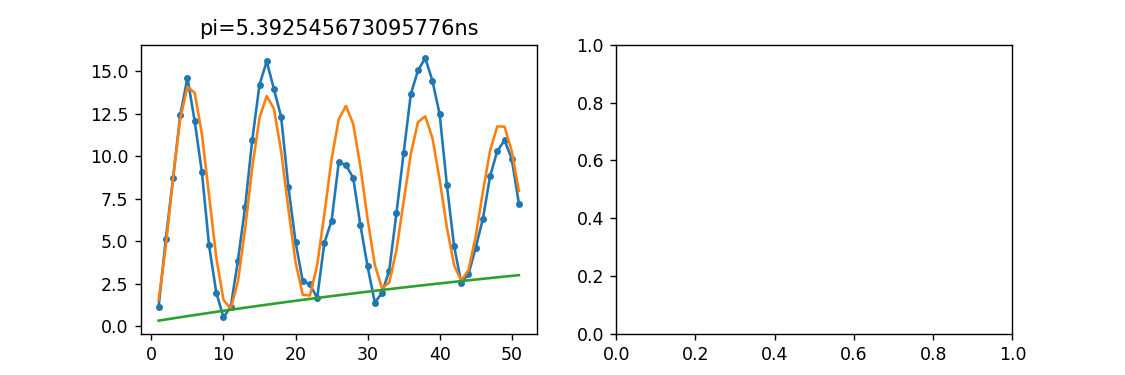

(7.607251440919935, 7.638604947494517, 20000, 0.09803921568627451, 0)


In [131]:
q_target = q1
t_rabi = np.linspace(1,51,51)
att_single = 30
tag = q_target.q_name
# await measure.attinst[q_target.inst['com']].set_att(att_single)
await psg[q_target.inst['ex_lo']].setValue('Output','ON')
await psg['psg_lo'].setValue('Output','ON')
# await mr.jpa_switch(measure,'ON')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex))
#     await cw.ats_setup(measure.ats,measure.delta,l=measure.readlen,repeats=(len(t_rabi)),awg=1)
job = Job(mrw.rabiTime, (measure,t_rabi,[q_target.q_name]), tags=[tag], max=len(t_rabi))
t_r, s_r = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,3))
t_op = []
for i in range(np.shape(s_r)[1]):
    x, y = t_r[:,i], np.abs(s_r[:,i])
    t_op.append(op.RowToRipe().firstMax(x,y,num=0,peakpercent=0.8))
    A,B,T1,w,phi,out = op.Rabi_Fit(envelopemethod='hilbert',phi=0).fitRabi(np.abs(x),np.abs(y))
    z = A*np.exp(-x/T1)*np.cos(2*np.pi*w*x+phi) + B
    env = A*np.exp(-x/T1) + B
    axes[0].plot(x,y,'-o',markersize=3)
    axes[0].plot(x,z)
    axes[0].plot(x,env)
    axes[0].set_title(f'pi={1/w/2}ns')
plt.show()

## Rabi_seq

In [240]:
q7.replace(envelopename=['hanning',1],nwave=1,amp=1,shift=200e-9,phase=0,phaseDiff=0,delta_ex=110e6,pi_len=50e-9,\
         seqtype='PDD',detune=3e6,DRAGScaling=None)
# q8.replace(envelopename=['hanning',1],nwave=1,amp=1,shift=200e-9,phase=0,phaseDiff=0,delta_ex=110e6,pi_len=40e-9,\
#          seqtype='PDD',detune=3e6,DRAGScaling=None)

In [212]:
measure.delta,measure.base,measure.readlen = q10.state[1:]
await mrw.RecoverInst(measure,state=q10.state[0])

Output()

(10.95016698534121, 12.200946121832416, 20000, 28.71287128712871, 0)
[0.06] [0.017477359347614758]


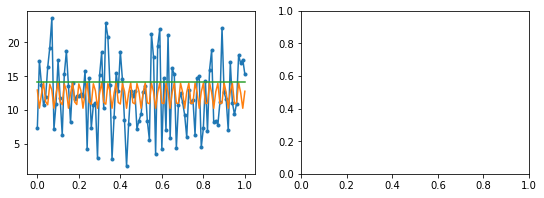

In [241]:
q_target = ['q7']
amp = np.linspace(0,1,101)
arg = 'amp'
comwave, readseq, mode = True, True, 'hbroadcast'

numrepeat, avg = (len(amp),False) if mode == 'hbroadcast' else (300,True)
job = Job(mrw.rabi_seq, (measure,amp,arg,q_target,comwave,readseq,mode), tags=q_target, max=numrepeat,avg=avg)
v_rp, s_rp = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,3))
t_op, t_fit = [], []
for i in range(np.shape(s_rp)[1]):
    x, y = v_rp[:,i], np.abs(s_rp[:,i])
    t_op.append(op.RowToRipe().firstMax(x,y,num=0,peakpercent=0.8))
    A,B,T1,w,phi,out = op.Rabi_Fit(envelopemethod='hilbert',phi=0).fitRabi(np.abs(x),np.abs(y))
    t_fit.append(1/w/2)
    z = A*np.exp(-x/T1)*np.cos(2*np.pi*w*x+phi) + B
    env = A*np.exp(-x/T1) + B
    axes[0].plot(x,y,'-o',markersize=3)
    axes[0].plot(x,z)
    axes[0].plot(x,env)
#     axes[0].set_title(f't_op={t_op}mv,pi={t_fit}mv')
print(t_op,t_fit)
plt.show()

In [204]:
q6.f_ex

4882817258.5367985

In [109]:
q10.amp = 0.23188

In [56]:
q9.pi_len

5e-08

# 优化Pi脉冲

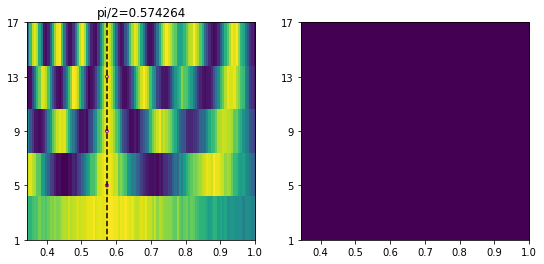

In [20]:
# q_target, nwave, wavlen = q10, 5, 101
# tag = q_target.q_name
# optwhich = 'amp'
# #await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex))
# job = Job(mrw.pipulseOpt, (measure,nwave,wavlen,optwhich,[q_target.q_name]), tags=[tag], max=nwave)
# n_pi, t_pi, s_pi = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
x, y, s = n_pi[:,0],t_pi[0][:,0], np.abs(s_pi[:,:,0])
index = y[np.argmax(np.abs(s),axis=1)[0]]
extent = [np.min(y),np.max(y),np.min(x),np.max(x)]
axes[0].set_yticks(x)
axes[0].imshow(np.abs(s),extent=extent,origin='lower',aspect='auto')
yop = np.array([op.RowToRipe().firstMax(y,z,num=0.57,peakpercent=0.9,insitu=True) for z in s])
axes[0].scatter(yop[1:-1],x[1:-1],marker='.',c='',edgecolors='m')
axes[0].vlines(np.mean(yop),np.max(x),np.min(x),'k','--')
axes[0].set_title('pi/2=%f'%np.mean(yop))
axes[1].set_yticks(x)
axes[1].imshow(np.angle(s),extent=extent,origin='lower',aspect='auto')
plt.show()

In [27]:
q10.amp = 0.574264

# AllXY dragdetune

Output()

<IPython.core.display.Javascript object>


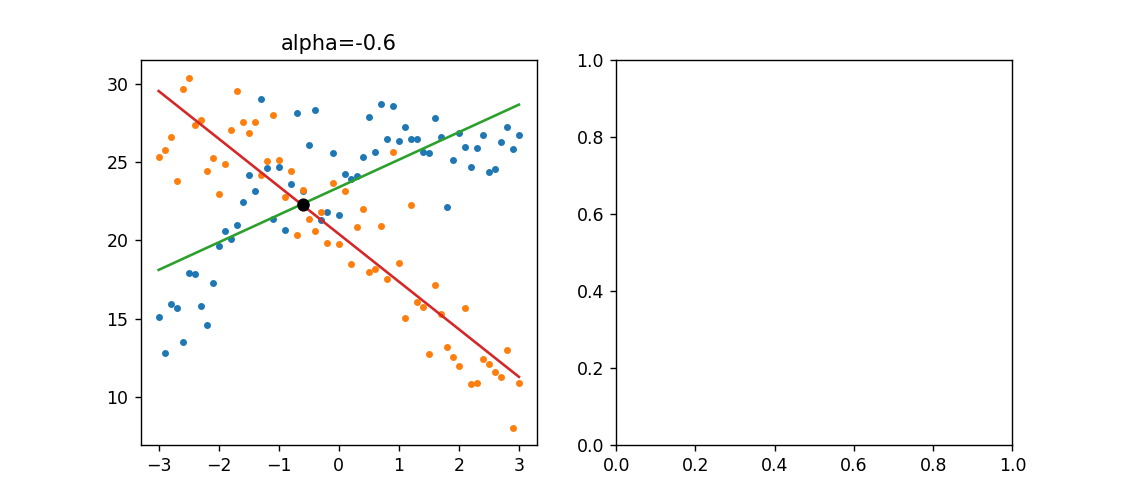

In [399]:
q_target = q8
#alpha = q_target.alpha
#await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex))
job = Job(mrw.AllXYdragdetune, (measure,[q_target.q_name]), tags=[q_target.q_name], max=122)
fall, sall = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
l = np.shape(fall)[0]//2
f1, f2, s1, s2 = fall[:l,0], fall[l:,0], np.abs(sall[:l,0]), np.abs(sall[l:,0])
z1 = np.poly1d(np.polyfit(f1,s1,1))(f1)
z2 = np.poly1d(np.polyfit(f2,s2,1))(f2)
index = np.argmin(np.abs(z1-z2))
axes[0].plot(np.array([f1,f2]).T,np.array([s1,s2]).T,'.')
axes[0].plot(np.array([f1,f2]).T,np.array([z1,z2]).T)
# axes[0].plot(fall[l:,:],np.abs(sall[l:,:]))
axes[0].plot([f1[index],f2[index]],[z1[index],z2[index]],'ko')
axes[0].set_title(f'alpha={round(f1[index],3)}')
plt.show()

In [ ]:
q1.DRAGScaling = 1/(q1.alpha*2*np.pi)

# AC_Stark

In [53]:
#波形尾部在 87 us处， 波形宽度为 500 ns
q1.replace(envelopename=['hanning',2],nwave=1,amp=1,shift=0e-9,phase=0,phaseDiff=0,delta_ex=110e6,pi_len=5.6e-9,\
         seqtype='PDD',detune=3e6)

## 单条

Output()

<IPython.core.display.Javascript object>


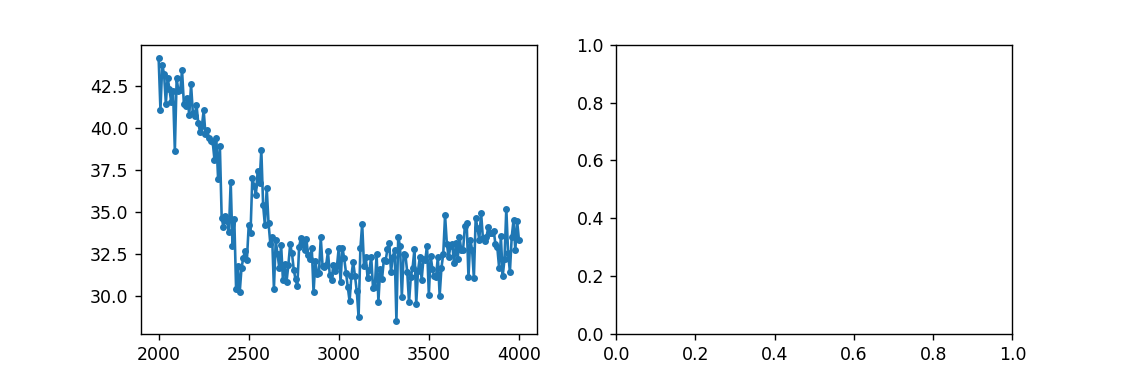

In [402]:
q_target = q8
t_rabi = np.linspace(2000,4000,201)
att_single = 30
tag = q_target.q_name
job = Job(mrw.singleacStark, (measure,t_rabi,[q_target.q_name]), tags=[tag], no_bar=True)
t_shift, s_ac = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,3))
for i in range(np.shape(s_ac)[1]):
    x, y = t_shift[:,i], np.abs(s_ac[:,i])
    axes[0].plot(x,y,'-o',markersize=3)
plt.show()

In [57]:
3425-3500

-75

In [27]:
q1.timing['read>xy'] = -75e-9

## 二维

In [278]:
q_target = q1
t_rabi = np.linspace(2000,4000,201)
att_single = 30
tag = q_target.q_name
# await measure.attinst[q_target.inst['com']].set_att(att_single)
# await psg[q_target.inst['ex_lo']].setValue('Output','ON')
# await psg['psg_lo'].setValue('Output','ON')
# await mr.jpa_switch(measure,'ON')
# await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex))
#     await cw.ats_setup(measure.ats,measure.delta,l=measure.readlen,repeats=(len(t_rabi)),awg=1)
job = Job(mrw.acStark, (measure,t_rabi,[q_target.q_name]), tags=[tag],max=51)
freq, t_shift, s_ac = await job.done()

Output()

ValueError: too many values to unpack (expected 2)

# Z脉冲

## 单条

In [35]:
#波形尾部在 87 us处， 波形宽度为 1000 ns
q1.replace(pi_len=10.8e-9)

Output()

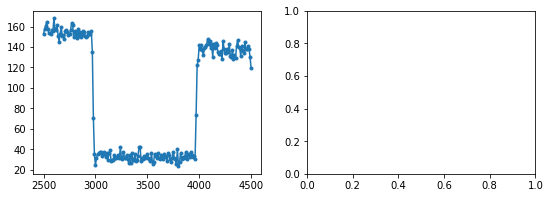

In [40]:
q_target = q10
t_rabi = np.linspace(2500,4500,201)
att_single = 30
tag = q_target.q_name
job = Job(mrw.singleZpulse, (measure,t_rabi,[q_target.q_name]), tags=[tag],no_bar=True)
t_shift, s_z = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,3))
for i in range(np.shape(s_z)[1]):
    x, y = t_shift[:,i], np.abs(s_z[:,i])
    axes[0].plot(x,y,'-o',markersize=3)
plt.show()

In [36]:
4250-4000

250

In [29]:
q10.timing['z>xy'] = 250e-9

## 二维

In [45]:
q_target = q10
t_rabi = np.linspace(2895,2995,251)
att_single = 30
tag = q_target.q_name
# await psg[q_target.inst['ex_lo']].setValuez('Frequency',(q_target.f_ex+q_target.delta_ex))
job = Job(mrw.zPulse, (measure,t_rabi,[q_target.q_name]), tags=[tag],max=31)
freq, t_shift, s_z = await job.done()

Output()

## 二维Population

In [135]:
q_target = q10
t_rabi = np.linspace(2900,3000,201)
which = measure.onwhich
tag = q_target.q_name
# await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex))
job = Job(mrw.zPulse_pop, (measure,t_rabi,which,[q_target.q_name]), tags=[tag],max=21)
freq, t_shift, s_z = await job.done()

Output()

In [106]:
np.shape(s_z)

(3, 3, 1)

In [107]:
s_z

array([[[0.02749209],
        [0.03026108],
        [0.00830696]],

       [[0.02610759],
        [0.02788766],
        [0.0272943 ]],

       [[0.00632911],
        [0.00454905],
        [0.03619462]]])

In [90]:
x = np.array([[1,2,3],[2,3,4],[1,1,3]])
y = np.array([[9,8,7],[4,5,6],[3,45,8]])
[list(zip(x[:,i],y[:,i])) for i in range(3)]

[[(1, 9), (2, 4), (1, 3)], [(2, 8), (3, 5), (1, 45)], [(3, 7), (4, 6), (3, 8)]]

# T1

In [61]:
measure.onwhich

[1]

In [34]:
q1.replace(envelopename=['hanning',2],nwave=1,amp=1,shift=0e-9,phase=0,phaseDiff=0,delta_ex=110e6,pi_len=4.2e-9,\
         seqtype='PDD',detune=3e6)

Output()

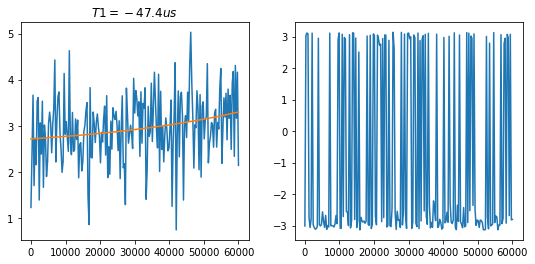

In [35]:
t_T1, q_target = np.linspace(0,60000,201,endpoint=True), q1
# await psg_ex1.setValue('Moutput','OFF')
job = Job(mrw.T1, (measure,t_T1,[q_target.q_name]), tags=[q_target.q_name], max=len(t_T1))
t_t, s_t = await job.done()
A, B, T1 = op.Exp_Fit().fitExp(t_t[:,0],np.abs(s_t[:,0]))
z = A * np.exp(-t_t[:,0]*T1) + B
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_t,np.abs(s_t))
axes[0].plot(t_t[:,0],z)
axes[0].set_title('$T1=%.1fus$'%(1/T1/1000))
axes[1].plot(t_t,np.angle(s_t))
plt.show()

# T1_seq

In [139]:
q1.replace(pi_len=10.6e-9)

Output()

<IPython.core.display.Javascript object>


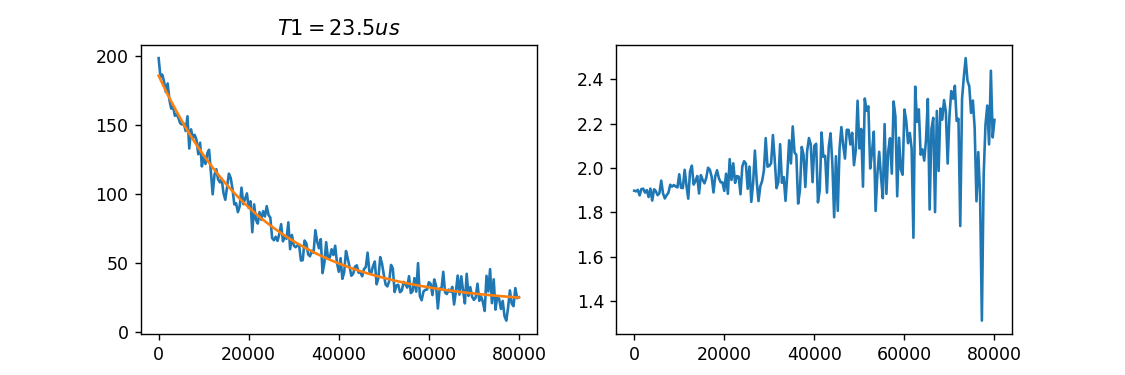

In [151]:
q_target = q10
t_rabi = np.linspace(0,80000,201)
att_single = 30
tag = q_target.q_name
# await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex))
job = Job(mrw.T1_seq, (measure,t_rabi,[q_target.q_name],False), tags=[tag], max=300,avg=True)
t_t, s_t = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,3))
A, B, T1 = op.Exp_Fit().fitExp(t_t[:,0],np.abs(s_t[:,0]))
z = A * np.exp(-t_t[:,0]*T1) + B
axes[0].plot(t_t,np.abs(s_t))
axes[0].plot(t_t[:,0],z)
axes[0].set_title('$T1=%.1fus$'%(1/T1/1000))
axes[1].plot(t_t,np.angle(s_t))
plt.show()

# Ramsey

In [29]:
q5.replace(envelopename=['hanning',1],nwave=0,amp=1,shift=0e-9,phase=0,phaseDiff=0,delta_ex=110e6,pi_len=16e-9,\
         seqtype='PDD',detune=3e6)

Output()

(25.21809573434976, 34.67037520967424, 30000, 1293.0430514125878, 0.0029850746268656712, 0)


<IPython.core.display.Javascript object>


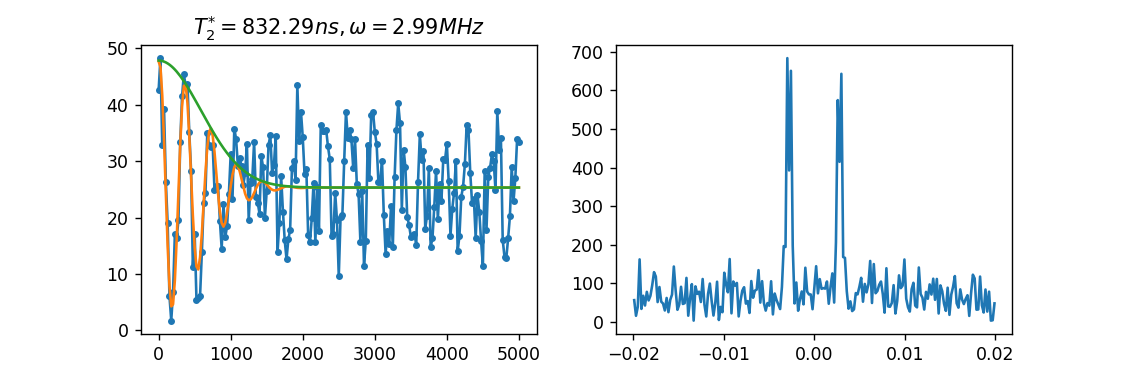

In [40]:
t_Ramsey, q_target = np.linspace(0,5000,201), ['q5']
# await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex))

job = Job(mrw.Ramsey, (measure,t_Ramsey,q_target), tags=q_target, max=len(t_Ramsey))
t_ram, s_ram = await job.done()
x, y = t_ram[:,0], (s_ram[:,0])
A,B,T1,T2,w,phi,out = op.T2_Fit(T1=30000,funcname='gauss',envelopemethod='hilbert').fitT2(x,np.abs(y))
z = A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B
z_env = A*np.exp(-(x/T2)**2-x/T1/2) + B
w,yt,amp = op.RowToRipe().fourier(x,y)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,3))
axes[0].plot(t_ram,np.abs(s_ram),'-o',markersize=3)
axes[0].plot(x,z)
axes[0].plot(x,z_env)
axes[0].set_title('$T_{2}^{*}=%.2fns,\omega=%.2fMHz$'%(T2,w*1e3))
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
plt.show()

# ramsey_seq

In [125]:
q10.replace(nwave=0,seqtype='PDD',detune=3e6)
# await cww.clearSeq(measure,['awg133','awg134'])

Output()

(100.32791612392447, 219.65508448146852, 30000, 3633.7016661595385, 0.0025870646766169153, 0)


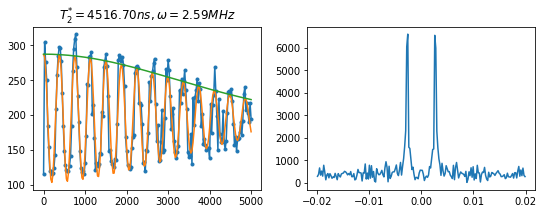

In [141]:
q_target = ['q10']
t_Ramsey = np.linspace(0,5000,201)
att_single = 30
comwave, readseq, mode = True, True, 'hbroadcast'

numrepeat, avg = (len(t_Ramsey),False) if mode == 'hbroadcast' else (300,True)
job = Job(mrw.Ramsey_seq, (measure,t_Ramsey,q_target,comwave,readseq,mode), tags=q_target, max=numrepeat,avg=avg)
t_ram, s_ram = await job.done()
x, y = t_ram[:,0], (s_ram[:,0])
A,B,T1,T2,w,phi,out = op.T2_Fit(T1=30000,funcname='gauss',envelopemethod='hilbert').fitT2(x,np.abs(y))
z = A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B
z_env = A*np.exp(-(x/T2)**2-x/T1/2) + B
w,yt,amp = op.RowToRipe().fourier(x,y)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,3))
axes[0].plot(t_ram,np.abs(s_ram),'-o',markersize=3)
axes[0].plot(x,z)
axes[0].plot(x,z_env)
axes[0].set_title('$T_{2}^{*}=%.2fns,\omega=%.2fMHz$'%(T2,w*1e3))
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
plt.show()

In [446]:
f = await  psg[q_target.inst['ex_lo']].getValue('Frequency')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(f-w*1e9+3e6))
print(f)

4939300000.0


In [136]:
measure.steps = 101

# SpinEcho

In [46]:
q1.replace(envelopename=['hanning',2],nwave=1,amp=1,shift=0e-9,phase=0,phaseDiff=0,delta_ex=110e6,pi_len=12e-9,\
         seqtype='CPMG',detune=3e6)

In [145]:
t_spin, q_target = np.linspace(0,15000,301), q1
# await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])

job = Job(mrw.SpinEcho, (measure,t_spin,[q_target.q_name]), tags=[q_target.q_name], max=len(t_spin))
t_sp, s_sp = await job.done()
x, y = t_sp[:,0], s_sp[:,0]
A,B,T1,T2,w,phi,out = op.T2_Fit(T1=100000,funcname='gauss',envelopemethod='hilbert').fitT2(x,np.abs(y))
z = A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B
z_env = A*np.exp(-(x/T2)**2-x/T1/2) + B
w,yt,amp = op.RowToRipe().fourier(x,y)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(x,np.abs(y),'-o',markersize=3)
axes[0].plot(x,z)
axes[0].plot(x,z_env)
axes[0].set_title('$T_{2}=%.2fus,w=%fMHz$'%(np.abs(T2/1000),w*1e3))
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
plt.show()

Output()

TypeError: cannot unpack non-iterable NoneType object

# SpinEcho_seq

In [45]:
q5.replace(nwave=1,amp=1,pi_len=16e-9,seqtype='CPMG',detune=1e6)

Output()

(28.837850125826847, 38.976394221010466, 50000, 8212.221615294793, 0.0009950248756218905, 0)


<IPython.core.display.Javascript object>


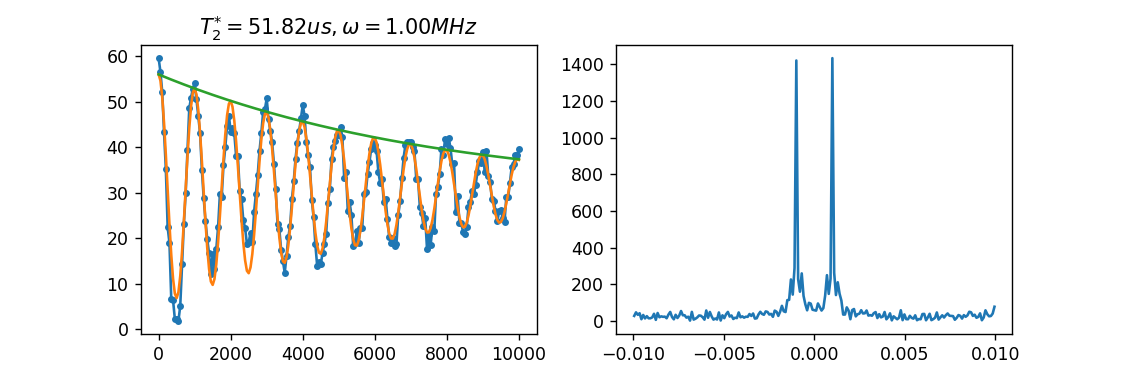

In [46]:
t_spin, q_target = np.linspace(0,10000,201), ['q5']
# await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex))

job = Job(mrw.SpinEcho_seq, (measure,t_spin,q_target,True), tags=q_target, max=500, avg=True)
t_sp, s_sp = await job.done()
x, y = t_sp[:,0], (s_sp[:,0])
A,B,T1,T2,w,phi,out = op.T2_Fit(T1=50000,funcname='gauss',envelopemethod='hilbert').fitT2(x,np.abs(y))
z = A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B
z_env = A*np.exp(-(x/T2)**2-x/T1/2) + B
w,yt,amp = op.RowToRipe().fourier(x,y)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,3))
axes[0].plot(x,np.abs(y),'-o',markersize=3)
axes[0].plot(x,z)
axes[0].plot(x,z_env)
axes[0].set_title('$T_{2}^{*}=%.2fus,\omega=%.2fMHz$'%(T2/1e3,w*1e3))
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
plt.show()

In [111]:
np.shape(t_sp)

(201, 1)

# Spec2d_awg

In [183]:
q1.replace(envelopename=['square',1],nwave=1,amp=1,shift=0e-9,phase=0,phaseDiff=0,delta_ex=120e6,pi_len=23e-9,\
         seqtype='CPMG',detune=3e6)

In [184]:
freq = np.arange(3.7,4.7,0.001)*1e9
bits = [q1]
await psg_trans.setValue('Power',0)
# await measure.attinst['com8'].set_att(20)
for k, i in enumerate(bits):
#     await measure.attinst['com9'].set_att(25)
    await mrw.jpa_switch(measure,'ON')
    print(i.q_name)
    job = Job(mrw.spec2d_awg, (i,measure,freq,None), tags=[i.q_name], max=61)
    v_s2, f_s2, s_s2 = await job.done()

q1


Output()

# 优化读出点

In [704]:
q9.replace(pi_len=36.1e-9)

Output()

<IPython.core.display.Javascript object>


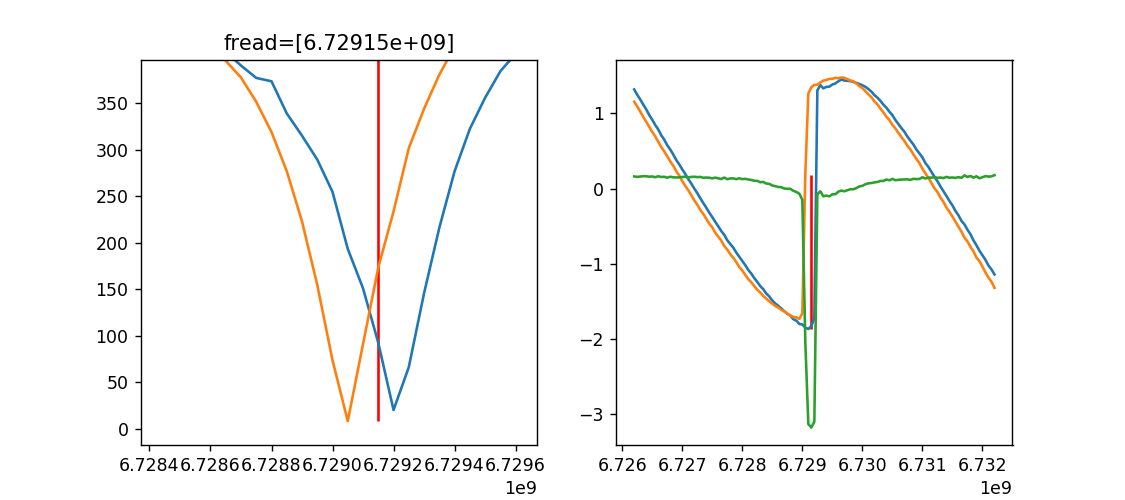

In [118]:
# q_target = q10
# await measure.attinst['com8'].set_att(30)
# await measure.attinst[q_target.inst['com']].set_att(q_target.power_rabi)
await mrw.jpa_switch(measure,state='ON')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex))
job = Job(mrw.readOp, (measure,['q10']), tags=['q10'], max=2)
st, f_op, s_op= await job.done()
f_lo = []
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
for i in range(measure.n):
    f, s_off, s_on = f_op[:,:,i][0], s_op[:,:,i][0], s_op[:,:,i][1]
    f_lo1 = (f[np.argmin(np.abs(s_off))] + f[np.argmin(np.abs(s_on))])/2
    x_off, y_off = op.RowToRipe().deductPhase(f,s_off)
    x_on, y_on = op.RowToRipe().deductPhase(f,s_on)
    anglediff = (np.angle(y_off[0])-np.angle(y_on[0]))
    index = np.abs(anglediff).argmax(axis=0)
    #index = np.abs(s_off).argmin(axis=0)
    f_lo.append(f[index] if np.abs(f[index]-f_lo1)<0.1e6 else f_lo1)
    axes[0].plot(f_op[:,:,i].T,np.abs(s_op[:,:,i].T))
    axes[0].vlines(f_lo,np.max(np.abs(s_op[:,:,i].T)),np.min(np.abs(s_op[:,:,i].T)),'r')
    axes[1].plot(x_off,np.angle(y_off[0]))
    axes[1].plot(x_on,np.angle(y_on[0]))
    axes[1].plot(x_off,anglediff)
    axes[1].vlines(f_lo,np.max(anglediff),np.min(np.angle(y_off[0])),'r')
plt.show()
f_lo, delta, n = await mrw.resn(np.array(f_lo))
measure.f_lo, measure.delta, measure.n = f_lo, delta, n
axes[0].set_title(f'fread={f_lo-measure.delta}')
await psg['psg_lo'].setValue('Frequency',f_lo)

In [119]:
measure.f_lo

6749150000.0

# 临界判断

In [130]:
measure.readamp = 0.1398
pulse = await cww.modulation_read(measure,measure.delta,readlen=1200)

Output()

<IPython.core.display.Javascript object>


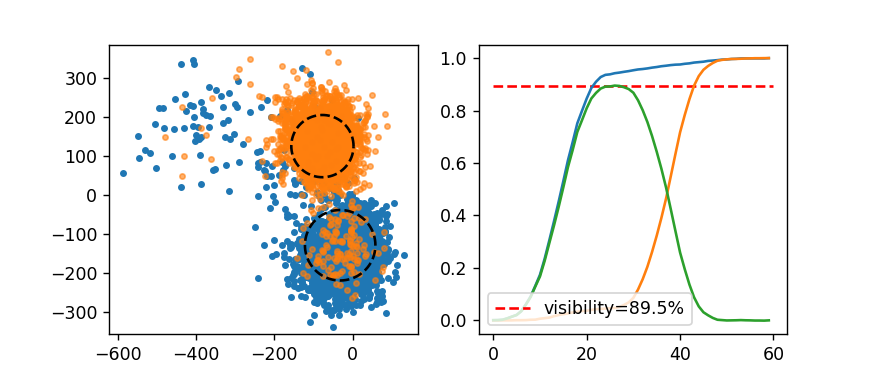

In [131]:
q_target = q10
# await measure.attinst['com8'].set_att(29)
await mrw.jpa_switch(measure,'ON')
job = Job(mrw.threshHold, (measure,[q_target.q_name]), tags=[q_target.q_name], max=2)
st, s_st, s_st_Q = await job.done()
num = measure.n
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(7,3*num))
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    data = await mrw.visibility(1,s_off,s_on)
    ax0 = axes[i][0] if num>1 else axes[i]
    ax0.plot(np.real(s_off),np.imag(s_off),'.')
    ax0.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
    ax0.plot(*(data[0][3]),'k--')
    ax0.plot(*(data[0][4]),'k--')
    ax0.axis('equal')
    ax1 = axes[i][1] if num>1 else axes[i+1]
    for j in data[0][:3]:
        ax1.plot(j)
    maxdata = np.max(data[0][2])
    ax1.hlines(maxdata,0,60,'r','--',label=f'visibility={round(maxdata*100,1)}%')
    ax1.legend(loc='lower left')
#     ax1.vlines([0],10,-100)
#     ax1.hlines([0],-10,100)

plt.show()

In [87]:
q10.shift = 0e-9

<IPython.core.display.Javascript object>


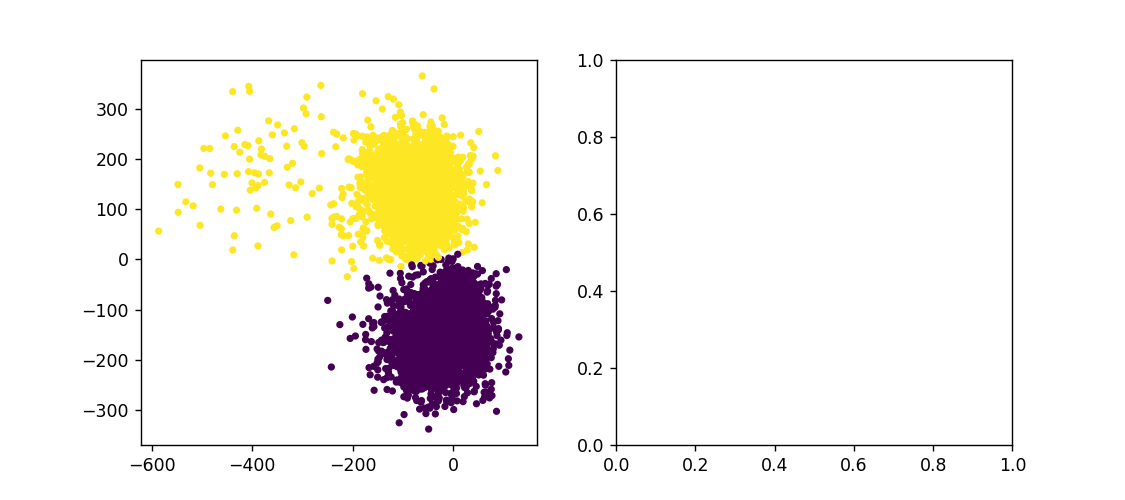

0.5053191489361702


In [132]:
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
predict = {}
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    S = list(s_off) + list(s_on)
    x,z = np.real(S), np.imag(S)
    d = list(zip(x,z))
    kmeans = KMeans(n_clusters=2,max_iter=100,tol=0.001)
    kmeans.fit(d)
    predict[measure.qubitToread[i]] = kmeans.predict
    y = kmeans.predict(d)
    print(list(y).count(1)/len(y))
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.scatter(x,z,c=y,s=10)
    ax.axis('equal')
plt.show()
measure.predict = predict

In [ ]:
kmeans.fit_predict

<IPython.core.display.Javascript object>


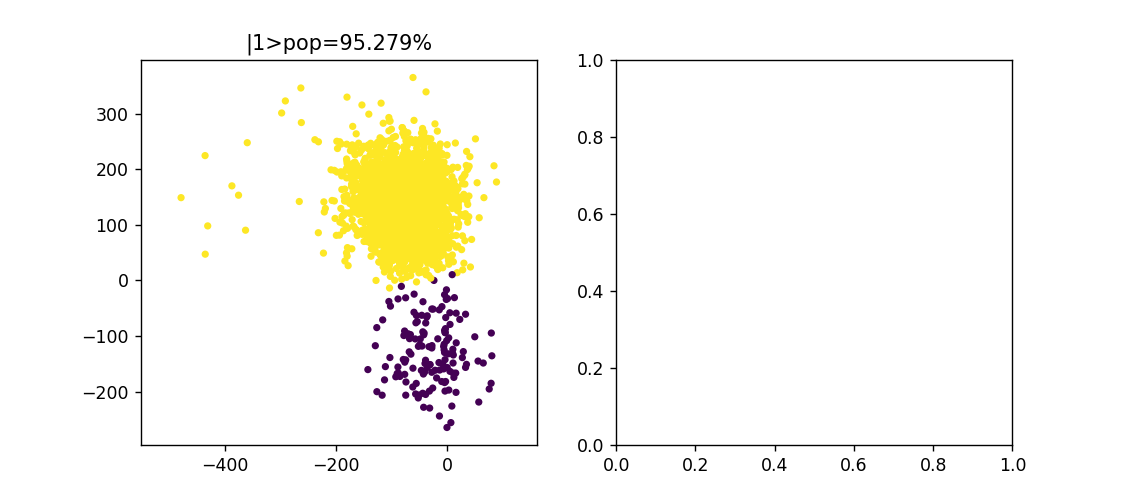

In [133]:
# sns.reset_orig()
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
onwhich, offwhich = [], []
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ss, which = s_on, 0
    d = list(zip(np.real(ss),np.imag(ss)))
    y = measure.predict[measure.qubitToread[i]](d)
    percent1 = list(y).count(which)/len(y)
    onwhich.append(which if percent1 > 0.5 else 1-which)
    offwhich.append(1-which if percent1 > 0.5 else which)
    percent = list(y).count(onwhich[i])/len(y)
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.scatter(np.real(ss),np.imag(ss),c=y,s=10)
    ax.set_title(f'|1>pop={round(percent*100,3)}%')
    ax.axis('equal')
plt.show()
measure.onwhich = onwhich
measure.offwhich = offwhich

<IPython.core.display.Javascript object>


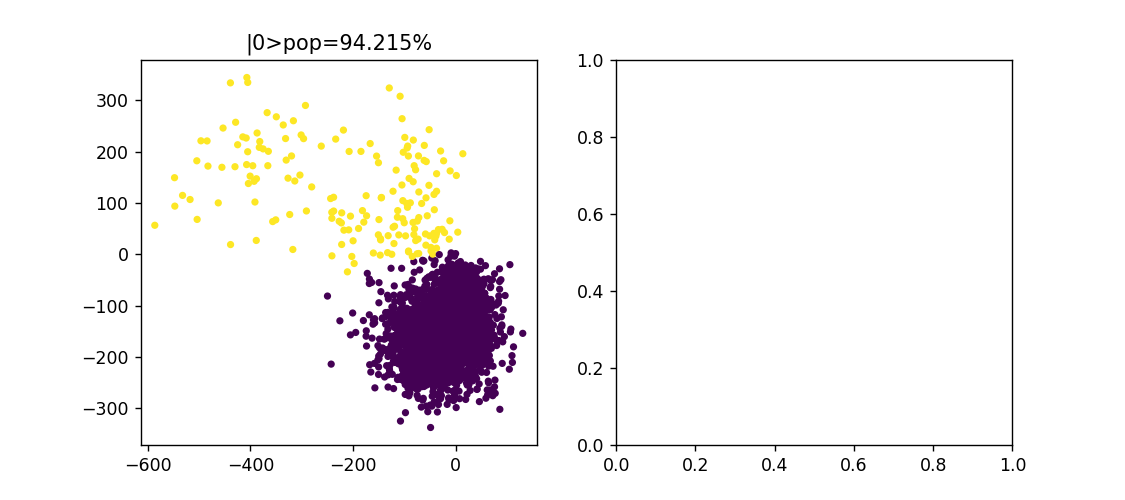

In [134]:
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ss, which = s_off, measure.offwhich[i]
    d = list(zip(np.real(ss),np.imag(ss)))
    y = measure.predict[measure.qubitToread[i]](d)
    percent = list(y).count(which)/len(y)
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.scatter(np.real(ss),np.imag(ss),c=y,s=10)
    ax.set_title(f'|0>pop={round(percent*100,3)}%')
    ax.axis('equal')
plt.show()

In [278]:
measure.readamp

0.0375

# JPA饱和功率

In [114]:
async def SaturationPower(readamp):
    n = measure.n
    for k in readamp:
        measure.readamp = k
        await cww.modulation_read(measure,measure.delta,readlen=measure.readlen,repeats=500)
        await cww.couldRun(measure.awg['awgread'])
        sm = []
        for j in ['OFF','ON']:
            await psg_pump.setValue('Output',j)
#             x = await psg_pump.getValue('Output')
#             print(x)
#             time.sleep(0.5)
            ch_A, ch_B,I,Q = await ats.getIQ()
            Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
            s = Am + 1j*Bm
#             print(j,np.abs(s))
            sm.append(s)
        yield [k]*n, sm[1]/sm[0]

<IPython.core.display.Javascript object>


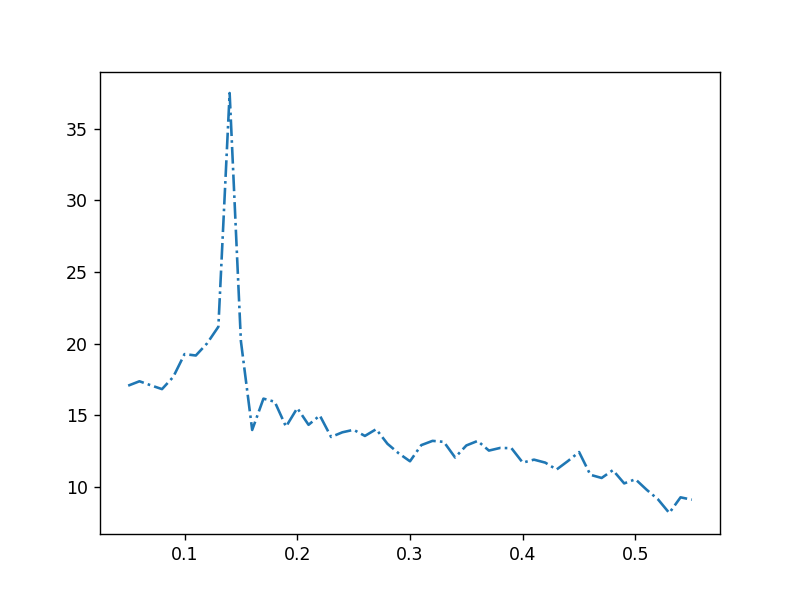

In [116]:
# readamp = np.linspace(0.05,0.55,51)
# await mrw.jpa_switch(measure,'ON')
# await psg_ex1.setValue("Output","OFF")
# job = Job(SaturationPower, (readamp,), tags=['jpa'], max=len(readamp))
# a_sp, s_sp = await job.done()
fig = plt.figure()
plt.plot(a_sp,20*np.log10(np.abs(s_sp)),'-.')
# plt.legend(loc=4,labels=['q%d'%(i+1) for i in range(10)])
plt.show()

In [956]:
measure.delta = np.array([30e6,70e6])

# 优化读出功率

<IPython.core.display.Javascript object>


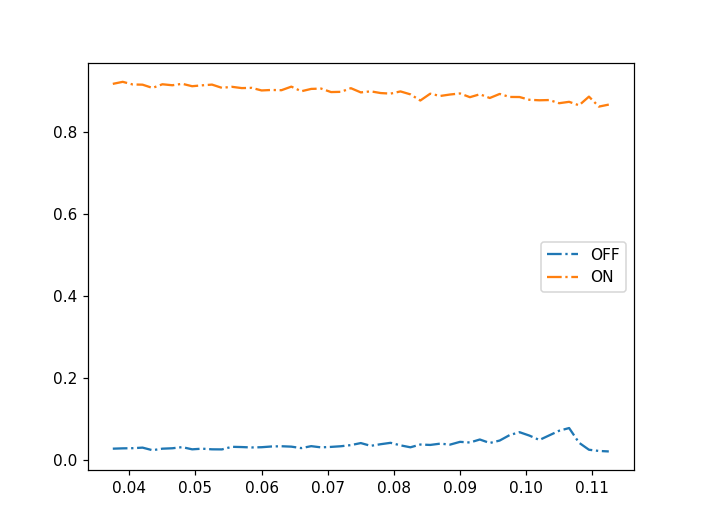

In [67]:
fig = plt.figure(num='readamp')

In [861]:
measure.delta

array([90750000., 50000000.])

In [68]:
q_target, which = q10, measure.onwhich
readamp = np.linspace(-0.5*measure.readamp,0.5*measure.readamp,51) + measure.readamp
# await measure.attinst['com8'].set_att(29)
await mrw.jpa_switch(measure,'ON')
for i in ['OFF','ON']:
    ex_lo_state = i
    await measure.psg[q_target.inst['ex_lo']].setValue('Output',ex_lo_state)
    job = Job(mrw.readpowerOpt, (measure,which,readamp), tags=[q_target.q_name], max=len(readamp))
    v_r, pop_r = await job.done()
    plt.figure(num='readamp')
    plt.plot(v_r,pop_r,'-.',label=ex_lo_state)
    plt.legend(loc='best')
    plt.show()

Output()

Output()

In [64]:
measure.readamp 

0.07500000000000001

In [319]:
readamp

array([0.1125, 0.117 , 0.1215, 0.126 , 0.1305, 0.135 , 0.1395, 0.144 ,
       0.1485, 0.153 , 0.1575, 0.162 , 0.1665, 0.171 , 0.1755, 0.18  ,
       0.1845, 0.189 , 0.1935, 0.198 , 0.2025, 0.207 , 0.2115, 0.216 ,
       0.2205, 0.225 , 0.2295, 0.234 , 0.2385, 0.243 , 0.2475, 0.252 ,
       0.2565, 0.261 , 0.2655, 0.27  , 0.2745, 0.279 , 0.2835, 0.288 ,
       0.2925, 0.297 , 0.3015, 0.306 , 0.3105, 0.315 , 0.3195, 0.324 ,
       0.3285, 0.333 , 0.3375])

# Crosstalk矫正

In [15]:
q2.state[1:]

[array([2.3460e+08, 2.1675e+08, 1.9195e+08, 1.7195e+08, 1.4925e+08,
        1.3745e+08, 1.3110e+08, 9.0700e+07, 7.0150e+07, 5.0000e+07]),
 array([ 27.1133277 +40.84700599j,  15.27891717+31.30870816j,
        -37.2044255 +13.79682795j,   1.66261582+38.94469575j,
         -1.53655794-37.59953255j, -46.06530544+19.91009578j,
        -18.98539628-16.82577704j,  11.52899392+58.56531026j,
         66.14295243-10.37695429j,  -3.85789619-85.54276185j]),
 1200]

In [16]:
bits = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]

v_rabi = np.linspace(-0.02,0.02,101)
for v, k in enumerate([q10]):
    count = 0
    q_target = k
    measure.delta,measure.base,measure.readlen = q_target.state[1:]
    await mrw.RecoverInst(measure,state=q_target.state[0])
    measure.delta = measure.delta[v:(v+1)]
    measure.readamp = 0.1
    await cww.modulation_read(measure,measure.delta,measure.readlen)
    await awg133.run()
    f_list = await ats.getValue('f_list')
#     await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
    for i,j in enumerate(bits):
        comwave = True if count == 0 else False
        q_bias = j
        if q_bias == q_target:
            continue
        else:
            tag = q_target.q_name + '_' + q_bias.q_name
            print(tag,f_list)
            job = Job(mrw.crosstalkSpec, (measure,v_rabi,[q_bias.q_name],[q_target.q_name],comwave), tags=[tag], max=11)
            v_ex, v_bias, s_sc = await job.done()
            await measure.awg[q_bias.inst['z_awg']].update_waveform(np.zeros((250000,)),f"ch{q_bias.inst['z_ch'][0]}")
            count += 1
    await mrw.InitInst(measure,psgdc=True,awgch=True)

q10_q1 [50000000.]


Output()

q10_q2 [50000000.]


Output()

q10_q3 [50000000.]


Output()

q10_q4 [50000000.]


Output()

q10_q5 [50000000.]


Output()

q10_q6 [50000000.]


Output()

q10_q7 [50000000.]


Output()

q10_q8 [50000000.]


Output()

q10_q9 [50000000.]


Output()

In [16]:
measure.n = 1

# 真空拉比

In [59]:
measure.delta,measure.base,measure.readlen = q10.state[1:]
await mrw.RecoverInst(measure,state=q10.state[0])

In [73]:
t_rabi, v_rabi = np.linspace(0,100,101), np.linspace(-0.3,-0.1,21)
# await psg[measure.qubits[q_target].inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex))
job = Job(mrw.vRabi, (measure,t_rabi,v_rabi,['q10'],['q9']), tags=['dc-q10','ex-q9'], max=len(t_rabi))
vv, tv, sv = await job.done()

Output()

In [1]:
q1.asdict()

NameError: name 'q1' is not defined

# pi脉冲振幅

In [1147]:
q_target = q10
t_rabi = np.linspace(1,501,201)
att_single = 35

com9 open...
last ATT 35.0
now ATT 35.0


Output()

<IPython.core.display.Javascript object>


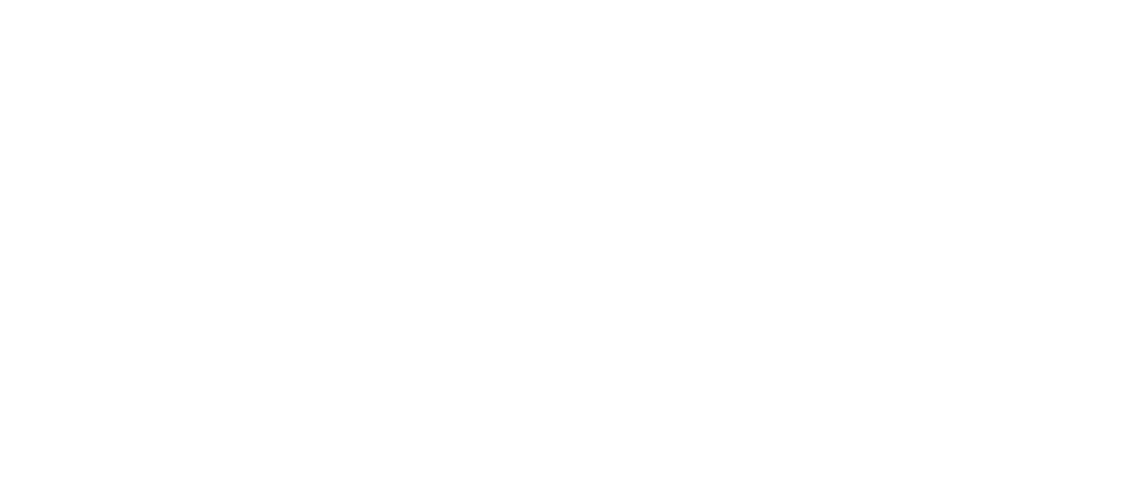

In [1149]:
tag = q_target.q_name
mr.Att_Setup(measure,q_target.inst['com']).Att(att_single)
await psg[q_target.inst['ex_lo']].setValue('Output','ON')
await psg['psg_lo'].setValue('Output','ON')
await mr.jpa_switch(measure,'ON')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.pipulseAmp, (q_target,measure,t_rabi), tags=[tag], max=9)
amp_pi, t_amp, s_amp = await job.done()
state = await mr.QueryInst(measure)
x, y , s = amp_pi[:,0], t_amp[0][:,0], s_amp[:,:,0]
wlist = [((op.RowToRipe().fourier(y,np.abs(i)))[0]) for i in s]
t_op = op.RowToRipe().firstMax(y,np.abs(s[-1]),num=0,peakpercent=0.7)
a = np.polyfit(x,wlist,1)
z = np.poly1d(a)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
extent = [np.min(y),np.max(y),np.min(x),np.max(x)]
axes[0].imshow(np.abs(s),extent=extent,origin='lower',aspect='auto')
axes[0].set_title('$pi/2=%.1f$'%t_op)
axes[1].set_yticks(x)
axes[1].plot(x,wlist,'.')
axes[1].plot(x,z(x))
axes[1].set_title(f'$grad={a[0]}$')
plt.show()

<IPython.core.display.Javascript object>


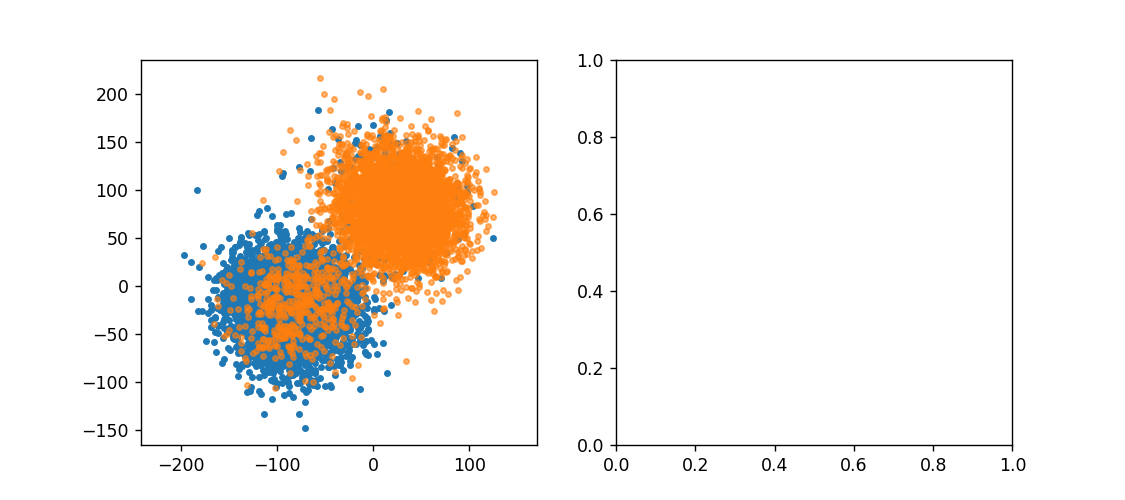

In [561]:
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
for i in range(measure.n):
    s_off, s_on = s_st_Q[0,:,i], s_st_Q[1,:,i]
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.plot(np.real(s_off),np.imag(s_off),'.')
    ax.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
#     ax.vlines([0],10,-100)
#     ax.hlines([0],-10,100)
    ax.axis('equal')
plt.show()

<IPython.core.display.Javascript object>


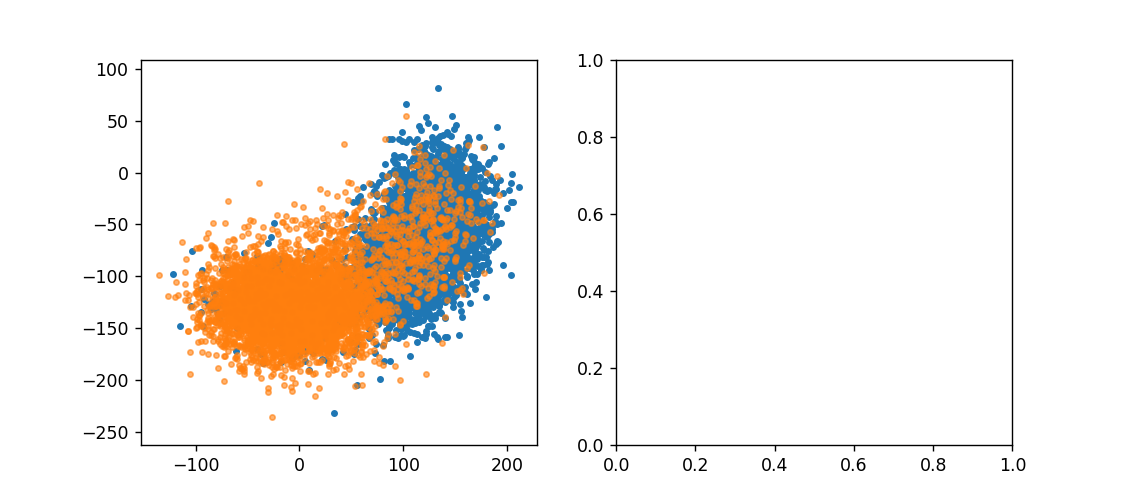

In [227]:
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.plot(np.real(s_off),np.imag(s_off),'.')
    ax.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
#     ax.vlines([0],10,-100)
#     ax.hlines([0],-10,100)
    ax.axis('equal')
plt.show()

## 测试

com7 open...
last ATT 13.5
now ATT 11.0


Output()

<IPython.core.display.Javascript object>


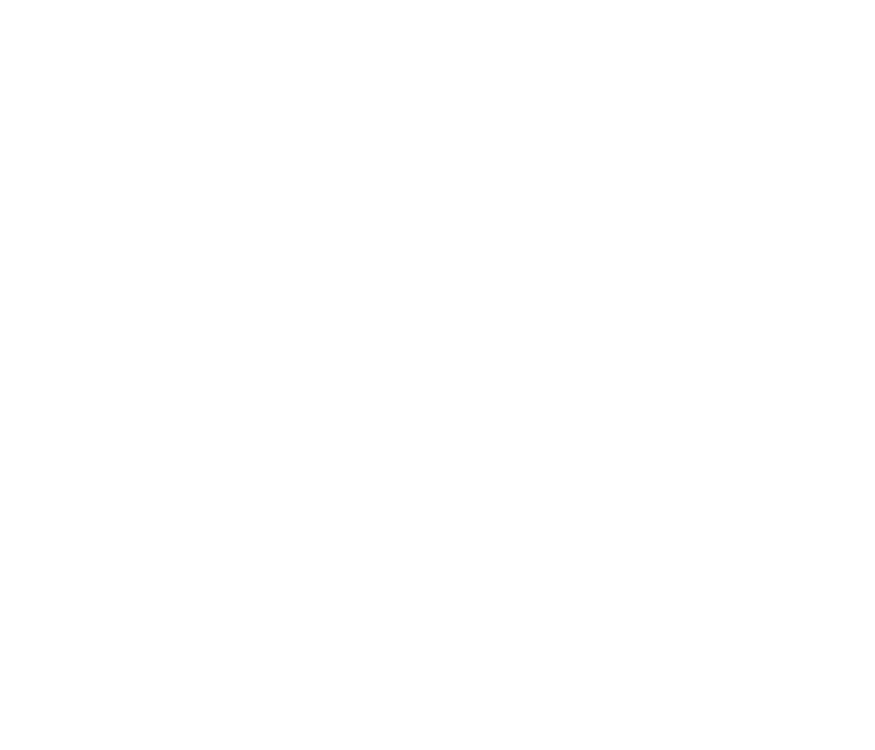

In [1134]:
exstate = {'q1':35,'q10':35}
# await measure.psg['psg_lo'].setValue('Power',13)
mr.Att_Setup(measure,'com7').Att(11)
job = Job(mr.threshHoldtest, (measure,True,exstate), tags=exstate.keys(), max=2)
st, s_st = await job.done()
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(7,3*num))
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.plot(np.real(s_off),np.imag(s_off),'.')
    ax.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
    ax.axis('equal')
plt.show()

<IPython.core.display.Javascript object>


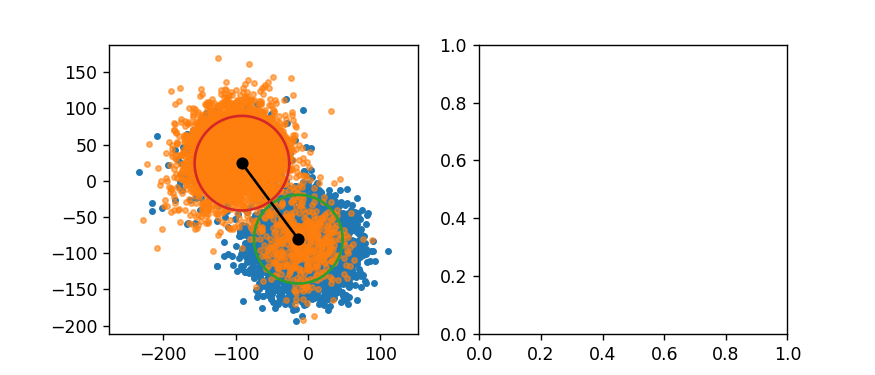

In [565]:
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(7,3*num))
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ax = axes[i//2][i%2] if num>1 else axes[i]
    x, y = s_off, s_on
    offmean, onmean = np.mean(x), np.mean(y)
    offstd, onstd = np.std(x), np.std(y)
    theta = np.arange(0, 2*np.pi, 0.01)
    roff = np.real(offmean) + offstd * np.cos(theta)
    ioff = np.imag(offmean) + offstd * np.sin(theta)
    ron = np.real(onmean) + onstd * np.cos(theta)
    ion = np.imag(onmean) + onstd * np.sin(theta)
    ax.plot(np.real(s_off),np.imag(s_off),'.')
    ax.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
    ax.axis('equal')
    ax.plot(roff,ioff)
    ax.plot([np.real(offmean),np.real(onmean)],[np.imag(offmean),np.imag(onmean)],'k-o')
    ax.plot(ron,ion)
plt.show()

<IPython.core.display.Javascript object>


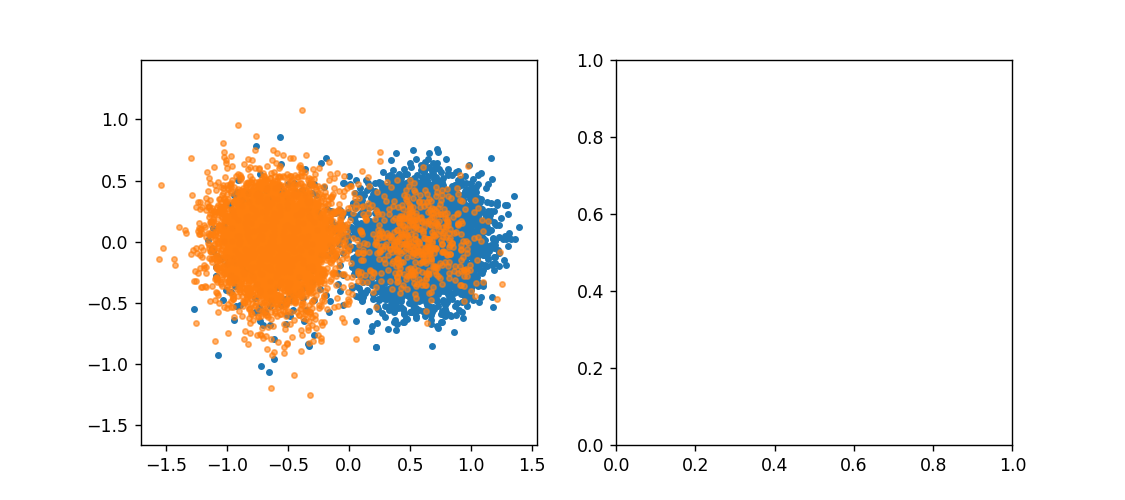

In [566]:
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ax = axes[i//2][i%2] if num>1 else axes[i]
    x, y = s_off, s_on
    add, diff = (np.mean(x)+np.mean(y))/2, np.mean(x)-np.mean(y)
    s_off, s_on = (x-add)/diff, (y-add)/diff
    ax.plot(np.real(s_off),np.imag(s_off),'.')
    ax.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
    ax.axis('equal')
plt.show()

In [252]:
measure.readlen

1200

In [1606]:
measure.qubitToread 

['q1']

0.4888251582278481


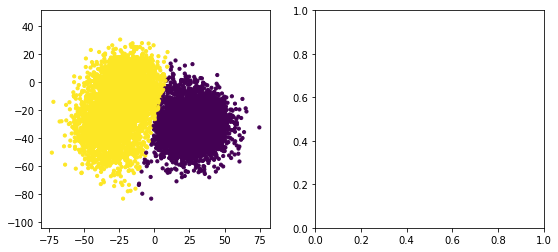

In [85]:
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
predict = {}
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    S = list(s_off) + list(s_on)
    x,z = np.real(S), np.imag(S)
    d = list(zip(x,z))
    kmeans = KMeans(n_clusters=2,max_iter=100,tol=0.001)
    kmeans.fit(d)
    predict[measure.qubitToread[i]] = kmeans.predict
    y = kmeans.predict(d)
    print(list(y).count(1)/len(y))
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.scatter(x,z,c=y,s=10)
    ax.axis('equal')
plt.show()
measure.predict = predict

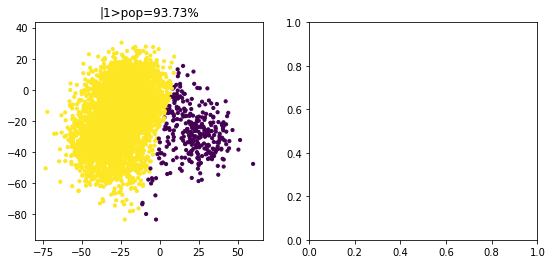

In [86]:
# sns.reset_orig()
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
onwhich, offwhich = [], []
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ss, which = s_on, 0
    d = list(zip(np.real(ss),np.imag(ss)))
    y = measure.predict[measure.qubitToread[i]](d)
    percent1 = list(y).count(which)/len(y)
    onwhich.append(which if percent1 > 0.5 else 1-which)
    offwhich.append(1-which if percent1 > 0.5 else which)
    percent = list(y).count(onwhich[i])/len(y)
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.scatter(np.real(ss),np.imag(ss),c=y,s=10)
    ax.set_title(f'|1>pop={round(percent*100,3)}%')
    ax.axis('equal')
plt.show()
measure.onwhich = onwhich
measure.offwhich = offwhich

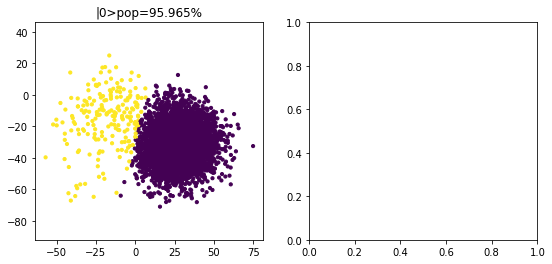

In [87]:
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ss, which = s_off, measure.offwhich[i]
    d = list(zip(np.real(ss),np.imag(ss)))
    y = measure.predict[measure.qubitToread[i]](d)
    percent = list(y).count(which)/len(y)
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.scatter(np.real(ss),np.imag(ss),c=y,s=10)
    ax.set_title(f'|0>pop={round(percent*100,3)}%')
    ax.axis('equal')
plt.show()

# rabiPopulation

com13 open...
last ATT 20.0
now ATT 20.0


Output()

<IPython.core.display.Javascript object>


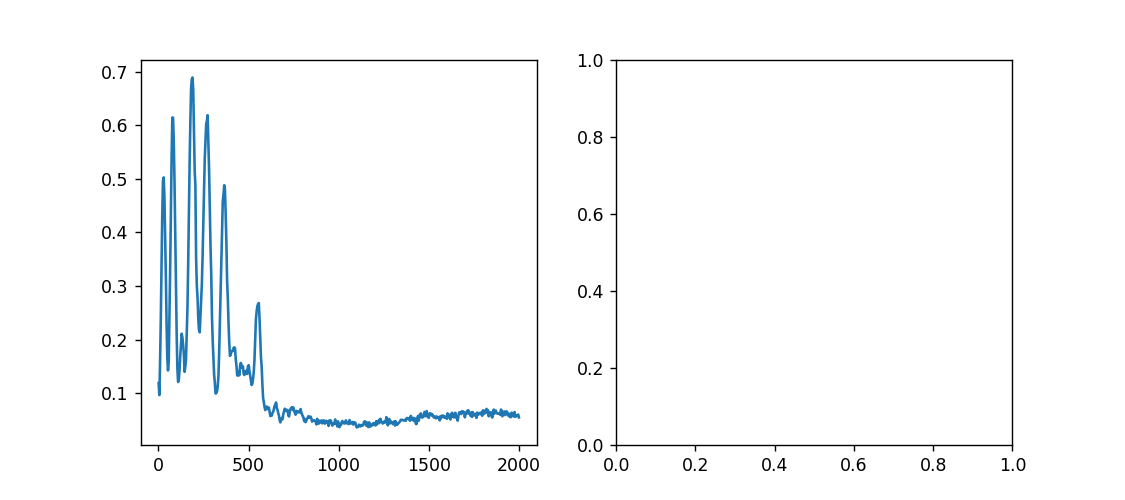

In [98]:
t_rabi, q_target, which = np.linspace(1,2001,501), q3, 1
att_single = 20
# measure.delta,measure.base,measure.readlen = q_target.state[1:]
# await mr.RecoverInst(measure,state=q_target.state[0])
mr.Att_Setup(measure,q_target.inst['com']).Att(att_single)
await psg_ex2.setValue('Output','OFF')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.rabiPop, (q_target,measure,t_rabi,which), tags=[tag], max=len(t_rabi))
t_rp, pop = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_rp[:,0],np.abs(pop[:,0]))
plt.show()

0.10700158227848101


<IPython.core.display.Javascript object>


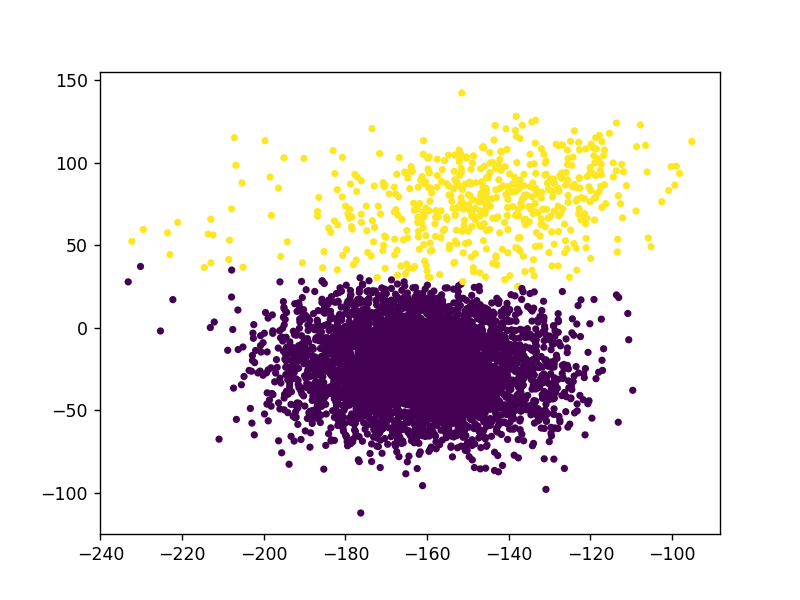

In [148]:
ss, which = pop[4,:,0], 1
d = list(zip(np.real(ss),np.imag(ss)))
y = measure.predict(d)
print(list(y).count(which)/len(y))
plt.figure()
plt.scatter(np.real(ss),np.imag(ss),c=y,s=10)
plt.show()

# 优化读出功率

Output()

<IPython.core.display.Javascript object>


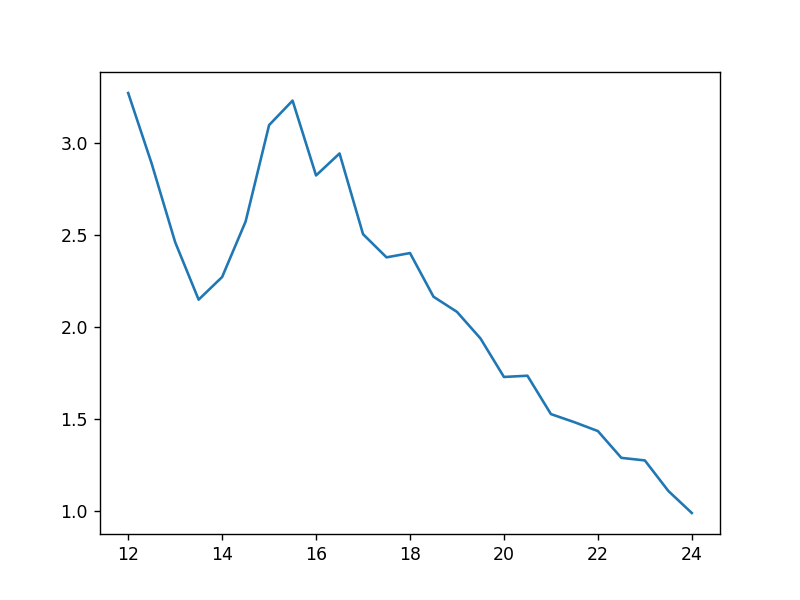

In [77]:
com, att = 'com7', np.linspace(12,24,25)
job = Job(mr.readpowerOpt, (q_target,measure,com,att), tags=[tag], max=len(att))
# attopt, popoff, popon = await job.done()
# plt.figure()
# plt.plot(attopt,popoff)
# plt.plot(attopt,popon)
# plt.show()
attopt, snr = await job.done()
plt.figure()
plt.plot(attopt,snr)
plt.show()

# pi脉冲优化

## sequance

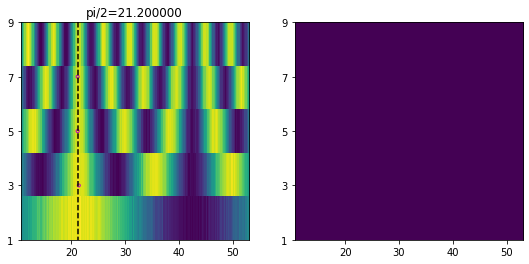

In [81]:
q_target, nwave, wavlen = q6, 5, len(t_rabi)
tag = q_target.q_name
# await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.pipulseOpt, (q_target,measure,nwave,wavlen), tags=[tag], max=nwave)
n_pi, t_pi, s_pi = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
x, y, s = n_pi[:,0],t_pi[0][:,0], np.abs(s_pi[:,:,0])
index = y[np.argmax(np.abs(s),axis=1)[0]]
extent = [np.min(y),np.max(y),np.min(x),np.max(x)]
axes[0].set_yticks(x)
axes[0].imshow(np.abs(s),extent=extent,origin='lower',aspect='auto')
yop = np.array([op.RowToRipe().firstMax(y,z,num=22,peakpercent=0.9,insitu=True) for z in s])
axes[0].scatter(yop[1:-1],x[1:-1],marker='.',c='',edgecolors='m')
axes[0].vlines(np.mean(yop),np.max(x),np.min(x),'k','--')
axes[0].set_title('pi/2=%f'%np.mean(yop))
axes[1].set_yticks(x)
axes[1].imshow(np.angle(s),extent=extent,origin='lower',aspect='auto')
plt.show()

In [82]:
q6 = q6._replace(pi_len=21.2,power_rabi=att_single,state=[state,measure.delta,measure.base,measure.readlen])

## waveform

Output()

<IPython.core.display.Javascript object>


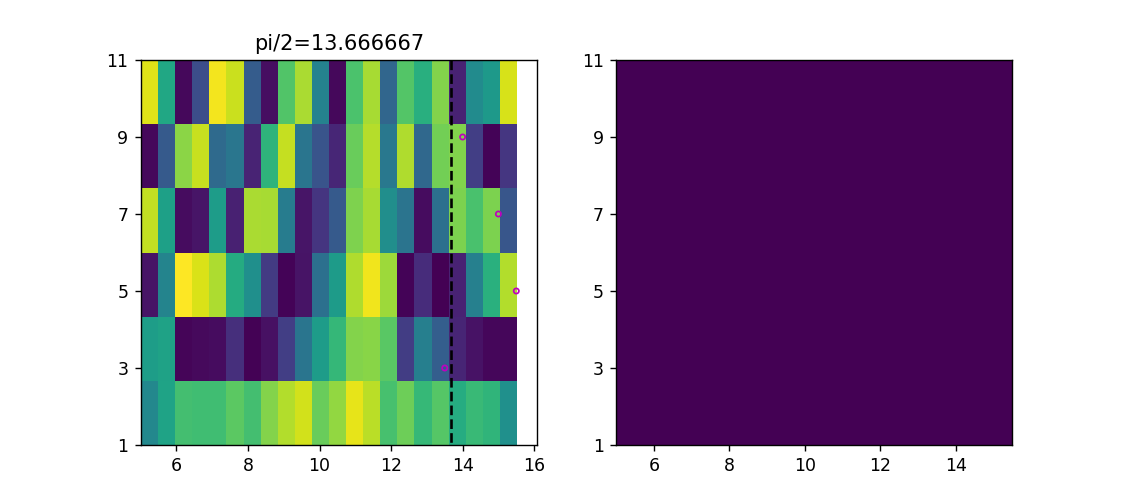

In [100]:
q_target, nwave, wavlen = q3, 6, len(t_rabi)
tag = q_target.q_name
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.pipulseOpt_waveform, (q_target,measure,nwave), tags=[tag], max=nwave)
n_pi, t_pi, s_pi = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
x, y, s = n_pi[:,0],t_pi[0][:,0], np.abs(s_pi[:,:,0])
index = y[np.argmax(np.abs(s),axis=1)[0]]
extent = [np.min(y),np.max(y),np.min(x),np.max(x)]
axes[0].set_yticks(x)
axes[0].imshow(np.abs(s),extent=extent,origin='lower',aspect='auto')
yop = np.array([op.RowToRipe().firstMax(y,z,num=16,peakpercent=0.9,insitu=True) for z in s])
axes[0].scatter(yop[1:-1],x[1:-1],marker='.',c='',edgecolors='m')
axes[0].vlines(np.mean(yop),np.max(x),np.min(x),'k','--')
axes[0].set_title('pi/2=%f'%np.mean(yop))
axes[1].set_yticks(x)
axes[1].imshow(np.angle(s),extent=extent,origin='lower',aspect='auto')
plt.show()

# pipulseDetune

Output()

Output()

Output()

<IPython.core.display.Javascript object>


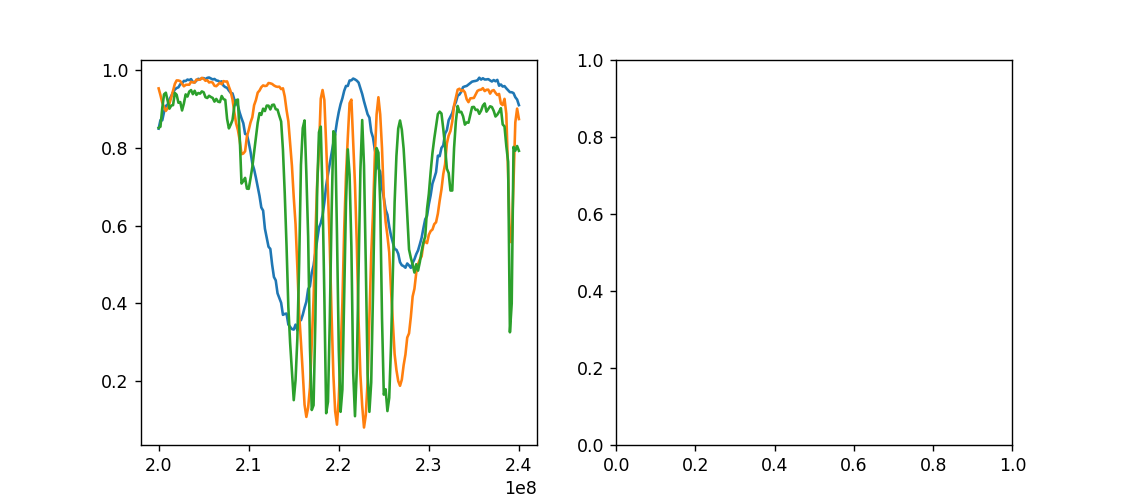

In [156]:
q_target, which = q6, measure.offwhich[0]
alpharatiodelta = -1/ q_target.alpha / (2*np.pi)
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
popn = []
for i in (1,5,10):
    job = Job(mr.detuneOpt, (q_target,measure,which,alpharatiodelta,i), tags=[q_target.q_name], max=201)
    f_op, pop = await job.done()
    popn.append(pop)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
for i in range(len(popn)):
    x, y = f_op[:,0], popn[i][:,0]
    axes[0].plot(x,np.abs(y))
plt.show()

In [ ]:
x, y1, y2 = f_op[:,0], popn[0][:,0], popn[1][:,0]
# f01 = op.RowToRipe().firstMax(x,y,num=(q_target.f_ex+q_target.delta_ex)[0],peakpercent=0.7)
index = np.argmin(np.abs(y1-y2))
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(x,np.abs(y1))
axes[0].plot(x,np.abs(y2))
axes[0].set_title('Delta_lo=%.4f MHz'%((x[index])/1e6))
plt.show()

# DragcoefHD

Output()

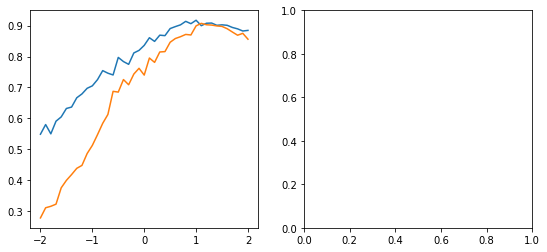

In [89]:
q_target, which, axis = q6, measure.onwhich[0], [['Xnhalf','Xhalf'],['Ynhalf','Yhalf']]
alpha = q_target.alpha * (2*np.pi)
# await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.dragcoefHD, (q_target,measure,which,alpha,axis,3), tags=[q_target.q_name], max=82)
f_op, s_op = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
l = np.shape(f_op)[0]//2
f1, f2, s1, s2 = f_op[:l,0], f_op[l:,0], np.abs(s_op[:l,0]), np.abs(s_op[l:,0])
axes[0].plot(f1,np.abs(s1))
axes[0].plot(f2,np.abs(s2))
plt.show()

# IQ-Mixer优化相位

Output()

<IPython.core.display.Javascript object>


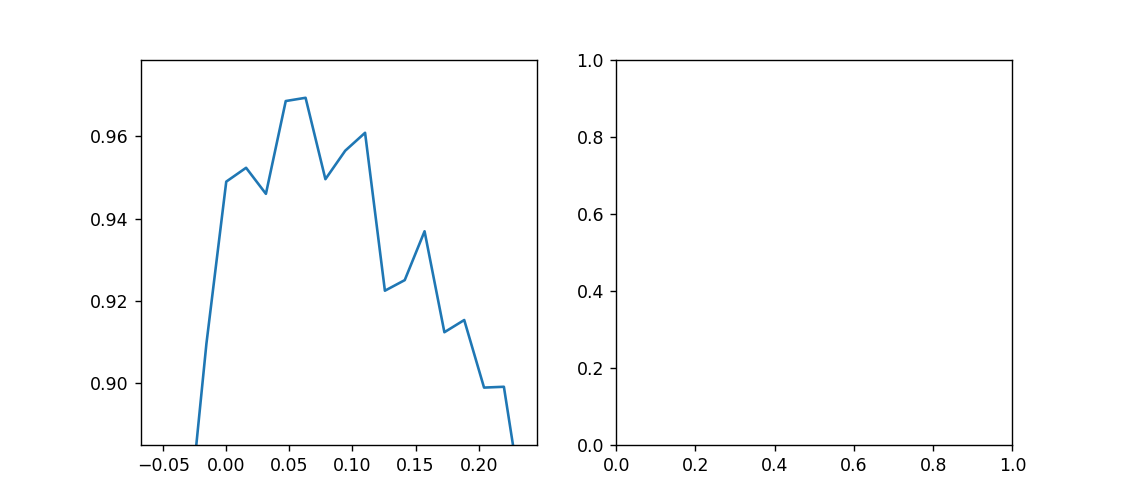

In [106]:
q_target, which = q6, measure.offwhich[0]
alpha = q_target.alpha
job = Job(mr.IQphaseOpt, (q_target,measure,which,5,alpha), tags=[q_target.q_name], max=201)
phase_op, pop = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(phase_op[:,0],np.abs(pop[:,0]))
plt.show()

In [84]:
await psg_ex1.setValue('Frequency',4.0576e9)

In [1232]:
qubit = q5
name, awg_target = [qubit.q_name+'_I', qubit.q_name+'_Q'], measure.awg[qubit.inst['ex_awg']]
await cw.genwaveform(measure,awg_target,name,qubit.inst['ex_ch'])
await cw.modulation_read(measure,measure.delta,tdelay=measure.readlen)
await measure.psg[qubit.inst['ex_lo']].setValue('Frequency',(qubit.f_ex)[0])
await measure.psg['psg_lo'].setValue('Output','ON')
ch1, ch2 = qubit.inst['ex_ch']
    
async def awgoffset(offset1,offset2):
    await awg_target.stop()
    await awg_target.setValue('Offset',offset1,ch=ch1)
    await awg_target.setValue('Offset',offset2,ch=ch2)
    await cw.couldRun(awg_target)
    await measure.psg[qubit.inst['ex_lo']].setValue('Output','ON')
    ch_A, ch_B = await measure.ats.getIQ()
    Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
    theta0 = np.angle(Am) - np.angle(Bm)
    Bm *= np.exp(1j*theta0)
    s = Am + Bm
    await measure.psg[qubit.inst['ex_lo']].setValue('Output','OFF')
    return np.abs(s - measure.base)

In [1233]:
# await cw.ats_setup(ats18,np.array([50e6]),l=1500,repeats=500)
opt.optimize(awgoffset,[-0.1,-0.5],[0.01,0.01],[3,3],high=[2,2],low=[-2,-2],print_info=True,algorithm='basinhopping')

.o
[-0.1 -0.5] [73.37549395]   .o
[-0.105 -0.5  ] [68.13018893]   ......................o
[-0.105 -0.501] [67.74947406]   .........................................................................o
[ 0.329 -0.831] [67.32442623]   ......................................................................................................................................................................................................................................................................................................o
[-0.115 -1.392] [66.53918799]   ...........................................................................................................................................................................................................................................................................................................................................................................................................................................................

                        fun: 53.40129378817715
 lowest_optimization_result:  final_simplex: (array([[-1.32537874, -0.79252065],
       [-1.32535275, -0.79256951],
       [-1.32529417, -0.79259195]]), array([53.40129379, 53.40129379, 53.40129379]))
           fun: 53.40129378817715
       message: 'Optimization terminated successfully.'
          nfev: 50
           nit: 19
        status: 0
       success: True
             x: array([-1.32537874, -0.79252065])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 1518
                        nit: 30
                          x: array([-1.325, -0.793])

# ramseyZpulse

Output()

<IPython.core.display.Javascript object>


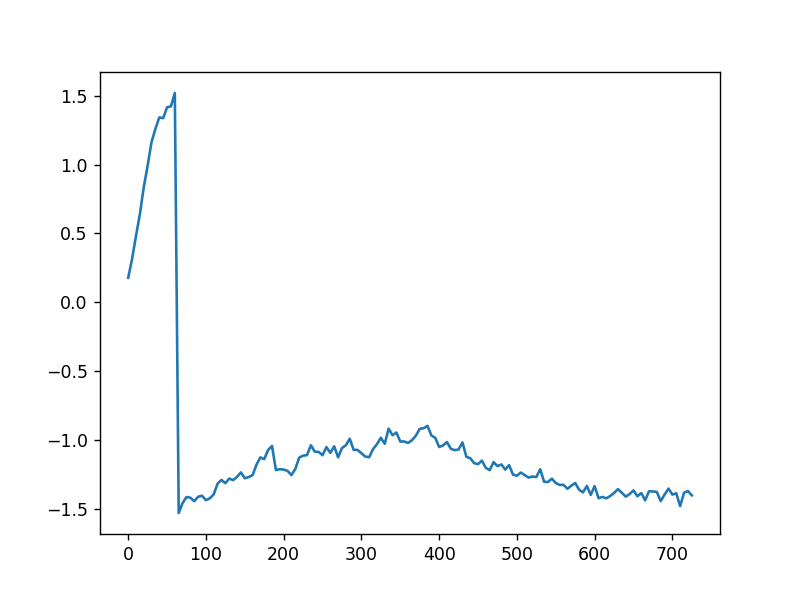

In [73]:
q_target, which, tcali = q6, measure.onwhich[0], 200
dragcoef = None
tdelay = np.arange(0,800,(q_target.pi_len/2),dtype=int)
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.ramseyZpulse, (q_target,measure,tdelay,which,tcali,dragcoef), tags=[q_target.q_name], max=len(tdelay))
t_rz, poplist_rz = await job.done()
coordinate = [[1-2*j[i] for i in range(2)] for j in poplist_rz]
theta = np.array([np.arctan(i[1]/i[0]) for i in coordinate])
plt.figure()
plt.plot(t_rz,theta)
plt.show()

In [59]:
j = 0
theta_new = []
theta_new.append(theta[0])
for i,j in enumerate(theta[1:],start=1):
    if theta_new[i-1]-j>np.pi/2:
        theta_new.append(j+np.pi/2)
    if theta_new[i-1]-j<-np.pi/2:
        theta_new.append(j-np.pi/2)

NameError: name 'theta' is not defined

# RamseyZpulse_chen

In [640]:
q_target, which, tcali = q6, measure.onwhich[0], 190
dragcoef = None
tdelay = np.arange(0,400,(q_target.pi_len/2),dtype=int)
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
t_rz,poplist_rz = [], []
for nozpulse in [True,False]:
    job = Job(mr.ramseyZpulse_chen, (q_target,measure,tdelay,which,tcali,dragcoef,nozpulse), tags=[q_target.q_name], max=len(tdelay))
    t, pop = await job.done()
    t_rz.append(t)
    poplist_rz.append(pop)

Output()

Output()

In [414]:
def test(theta):
    j = 0
    theta_new = []
    theta_new.append(theta[0])
    for i,j in enumerate(theta[1:],start=1):
        while 1:
            if theta_new[i-1]>j+0.8:
                j += np.pi
            else:
                break
        theta_new.append(j)
    return np.array(theta_new)

<IPython.core.display.Javascript object>


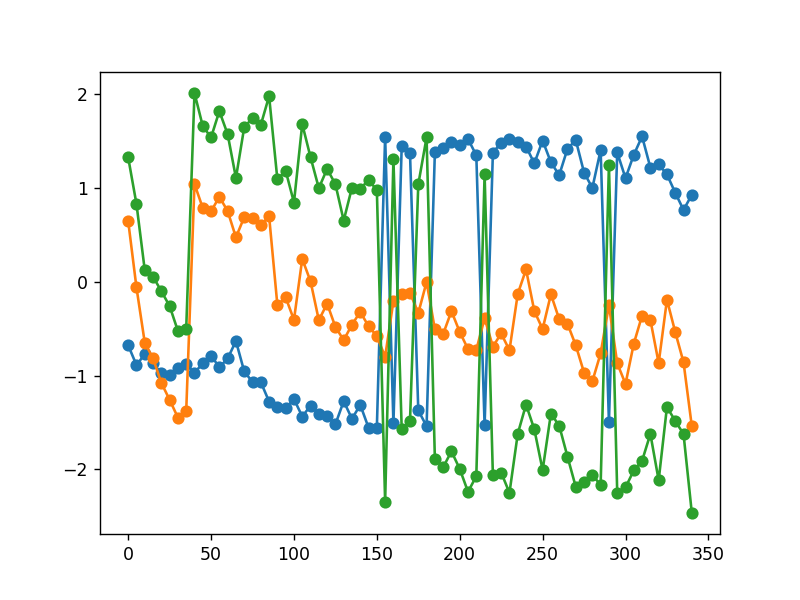

In [641]:
plt.figure()
t = t_rz[0][:,0]
pop_ref, pop_rz = poplist_rz[0], poplist_rz[1]
coordinate_ref = [[1-2*j[i] for i in range(2)] for j in pop_ref]
coordinate_rz = [[1-2*j[i] for i in range(2)] for j in pop_rz]
theta_ref = np.array([np.arctan(i[1]/i[0]) for i in coordinate_ref])
theta_rz = np.array([np.arctan(i[1]/i[0]) for i in coordinate_rz])

# theta_ref = test(theta_ref)
plt.plot(t,theta_ref,'-o')
# theta_rz = test(theta_rz)
plt.plot(t,theta_rz,'-o')
deltatheta = theta_rz - theta_ref
# deltatheta = test(deltatheta)
plt.plot(t,deltatheta,'-o')
plt.show()

In [398]:
np.shape(coordinate_rz)

(84, 2)

In [400]:
c 

[[0.163370253164557, 0.5688291139240507, 0],
 [0.08267405063291144, 0.5280854430379747, 0],
 [0.09335443037974689, 0.5704113924050633, 0],
 [0.08504746835443033, 0.5862341772151899, 0],
 [0.24564873417721522, 0.5803006329113924, 0],
 [0.24683544303797467, 0.5751582278481013, 0],
 [0.2784810126582279, 0.5510284810126582, 0],
 [0.02373417721518989, 0.4489715189873418, 0],
 [0.015427215189873444, 0.5344145569620253, 0],
 [-0.028481012658227778, 0.5284810126582278, 0],
 [0.15625, 0.5569620253164558, 0],
 [0.153876582278481, 0.5427215189873418, 0],
 [0.06685126582278478, 0.45767405063291144, 0],
 [0.27966772151898733, 0.4932753164556962, 0],
 [0.12223101265822789, 0.492879746835443, 0],
 [0.0035601265822784445, 0.4058544303797469, 0],
 [-0.015427215189873333, 0.461629746835443, 0],
 [-0.054193037974683556, 0.4612341772151899, 0],
 [-0.18868670886075956, 0.2689873417721519, 0],
 [-0.11867088607594933, 0.2954905063291139, 0],
 [-0.1586234177215189, 0.3817246835443038, 0],
 [-0.202136075949367

In [397]:
np.arctan(coordinate_rz[9][1]/coordinate_rz[9][0])

-1.5169561948215944

<IPython.core.display.Javascript object>


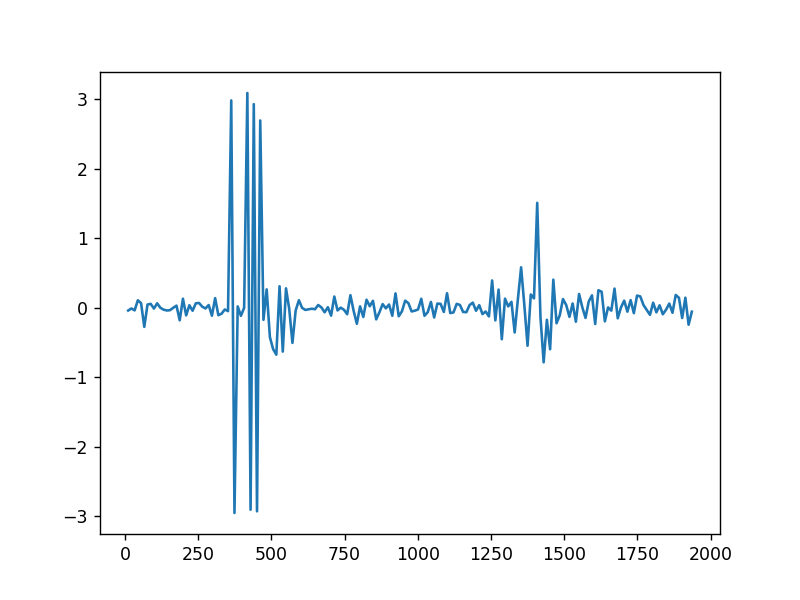

In [233]:
plt.figure()
deltatheta = np.diff(deltatheta)
plt.plot(t[1:],deltatheta)
plt.show()

# Zpulse_XY

Output()

<IPython.core.display.Javascript object>


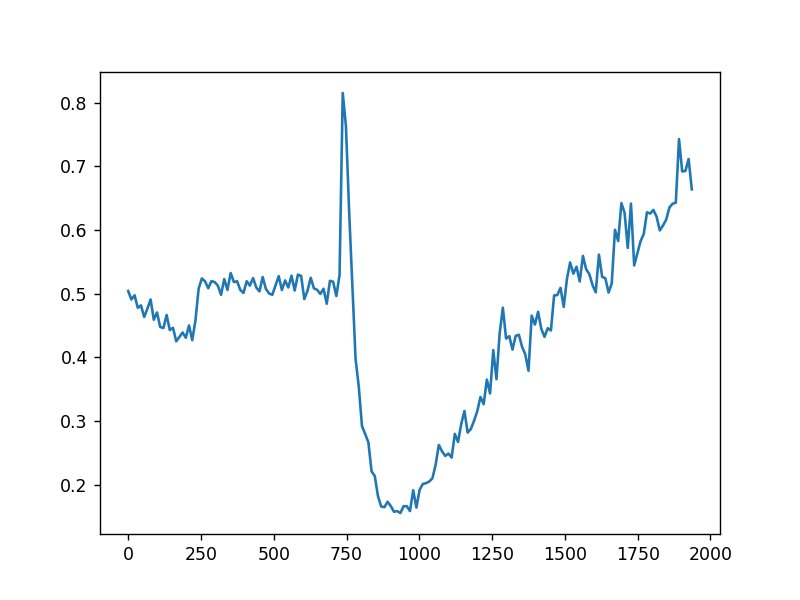

In [178]:
q_target, which, tcali = q6, measure.onwhich[0], 300
dragcoef = 1.4/q_target.alpha/2/np.pi
tdelay = np.arange(0,2000,(q_target.pi_len/2),dtype=int)
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.zPulse_XY, (q_target,measure,tdelay,which,tcali,dragcoef), tags=[q_target.q_name], max=len(tdelay))
t_xy, pop_xy = await job.done()
plt.figure()
plt.plot(t_xy,pop_xy)
plt.show()

<IPython.core.display.Javascript object>


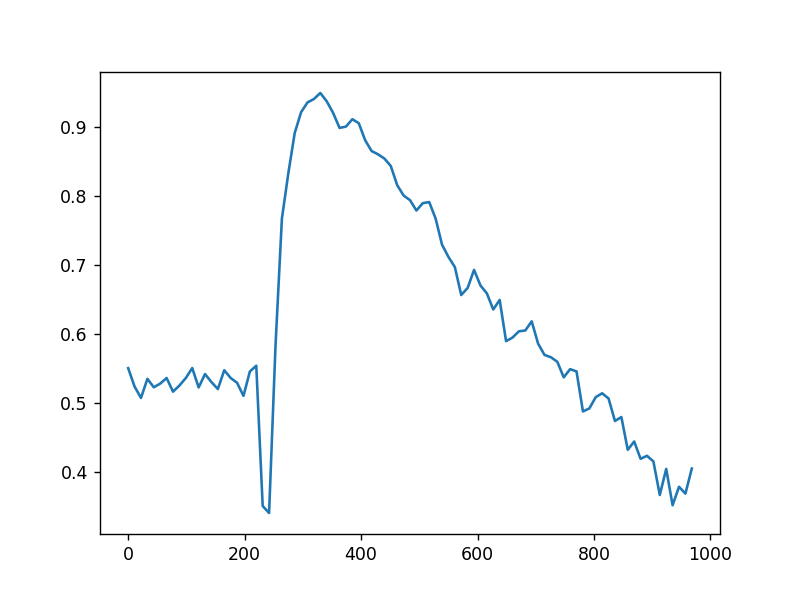

In [168]:
plt.figure()
plt.plot(t_xy,pop_xy)
plt.show()

# CrossTalk矫正

In [ ]:
t_rabi = np.linspace(0,100,201)
measure.wave['Read'] = [['Readout_I']*len(t_rabi),['Readout_Q']*len(t_rabi)]

In [ ]:
bits = [q1,q2,q3,q4,q5,q6,q7]
z_crosstalk = np.ones((10,10))

In [ ]:
# fig, axes = plt.subplots(ncols=7,nrows=7,figsize=(28,28))
%matplotlib inline
await mr.jpa_switch(measure,'ON')
for v,k in enumerate(bits,start=0):
    q_target = k
    print(q_target.q_name)
    measure.delta,measure.base,measure.readlen = q_target.state[1:]
    await mr.RecoverInst(measure,state=q_target.state[0])
    mr.Att_Setup(q_target.inst['com']).Att(q_target.power_rabi)
    for i,j in enumerate(bits):
        q_bias = j
        tag = q_target.q_name + '_' + q_bias.q_name
        if q_bias == q_target:
            if q_target.f_ex[0] > 3.9e9:
                v_rabi = np.linspace(-0.5,0.5,201)
            else:
                v_rabi = np.linspace(-0.05,0.05,201)
        else:
            v_rabi = np.linspace(-1,1,201)
        job = Job(mr.Z_cross, (q_target,q_bias,measure,v_rabi,(len(v_rabi)-1),True), tags=[tag], max=500,avg=True)
        v_Z, s_Z = await job.done()
#         await awg131.use_waveform(name='test',ch=i+1)
        await mr.InitInst(measure,psgdc=False,awgch=True)
        try:
            A, C, W, phi = op.Cos_Fit().fitCos(v_Z[:,0], np.abs(s_Z[:,0]))
        except Exception or RuntimeWarning:
            print('bad fitting')
            A, C, W, phi =0,0,0,0
        z = A*np.cos(2*np.pi*W*v_Z+phi)+C
        v_op = op.RowToRipe().firstMax(v_Z[:,0],np.abs(z[:,0]),num=0)
        W = -W if v_op < 0 else W
        z_crosstalk[v,i] = W
        plt.figure()
        plt.plot(v_Z,abs(s_Z))
        plt.plot(v_Z,z)
        plt.vlines(0,np.max(np.abs(s_Z[:,0])),np.min(np.abs(s_Z[:,0])),'r')
        plt.title(r'$%s-%s,W = %g,phi=%g,A=%g $' %(q_target.q_name,q_bias.q_name,W,phi,A))
        plt.show()
    await mr.InitInst(measure,psgdc=True,awgch=True)


In [ ]:
z_crosstalk

# 直流crosstalk矫正

In [574]:
dc_crosstalk = np.eye(10)

In [ ]:
bits = [q1,q2,q3,q4,q5,q6,q7]
await psg_trans.setValue('Power',13)
mr.Att_Setup(measure,'com8').Att(25)
# await cw.modulation_ex(q1,measure)
for v, k in enumerate(bits):
    q_target = k
    for i,j in enumerate(bits):
        q_bias = j
        if q_bias == q_target:
            continue
        else:
            tag = q_target.q_name + '_' + q_bias.q_name
            print(tag)
            job = Job(mr.dcCrosstalk, (q_target,q_bias,measure), tags=[tag], max=40)
            v_bias, s_sc = await job.done()
            x, y = v_bias[:,0], np.abs(s_sc[:,0])
            a,b,c,d,band = op.Lorentz_Fit().fitLorentz(x,y)
            ratio = -b/0.005
            dc_crosstalk[eval(q_target.q_name[1:]),eval(q_bias.q_name[1:])] = ratio
            z = a/(1.0+c*(x-b)**2)+d
            plt.figure()
            plt.plot(x,y)
            plt.plot(x,z)
            plt.title(tag+f'ratio={ratio}')
            plt.savefig(r'D:\skzhao\file_name\figure\%s.png'%tag)
            plt.close()
            clear_output()
            await mr.InitInst(measure,psgdc=True,awgch=False)
    await mr.InitInst(measure,psgdc=True,awgch=False)

# 二维谱

In [428]:
freq = np.arange(4.4,5.9,0.001)*1e9
bits = [q8]
#await measure.attinst['com8'].set_att(15)
for k, i in enumerate(bits):
#     await measure.attinst['com9'].set_att(27)
    await mr.jpa_switch(measure,'ON')
    print(i.q_name)
#     if k == 0:
#         await dc[bits_target[k+1].inst['dc']].DC(-1)
#     elif k == len(bits_target)-1:
#         await dc[bits_target[k-1].inst['dc']].DC(-1)
#     else:
#         await dc[bits_target[k-1].inst['dc']].DC(-1)
#         await dc[bits_target[k+1].inst['dc']].DC(-1)
    job = Job(mrw.spec2d, (i,measure,freq,None), tags=[i.q_name], max=36)
    v_s2, f_s2, s_s2 = await job.done()
    await mrw.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=None)
    clear_output()

In [417]:
measure.readamp=0.55

In [ ]:
np.linspace(-q3.T_bias[0]*0.3,q3.T_bias[0]*0.3,31) + q3.T_bias[1] 

# 二维谱AWG

In [12]:
data = np.load(r'D:\QuLabData\2020\1003\crosstalk_cali\zheng_crosstalk_q1-10_20201003123605.npz')
calimatrix = np.mat(data['mat'])

In [ ]:
freq = np.arange(4.5,5.95,0.001)*1e9
bits = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
# calimatrix=None
await psg_trans.setValue('Power',0)
# await measure.attinst['com8'].set_att(20)
for k, i in enumerate(bits):
#     await measure.attinst['com9'].set_att(25)
#     await mr.jpa_switch(measure,'ON')
    measure.delta,measure.base,measure.readlen = q7.state[1:]
    await mrw.RecoverInst(measure,state=q7.state[0])
    print(i.q_name)
    job = Job(mrw.spec2d_awg, (i,measure,freq,calimatrix), tags=[i.q_name], max=51)
    v_s2, f_s2, s_s2 = await job.done()
#     await mr.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=None)
#     clear_output()

q1


Output()

# RB_waveform

## reference

In [92]:
mlist, q_target, len_data, which, gate = np.logspace(0.4,2.8,16,dtype=int), q6, 30, measure.offwhich[0], False
dragcoef = 0.8/q_target.alpha/2/np.pi
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.RB_waveform,(q_target,measure,mlist,len_data,which,110e6,dragcoef,gate),tags=[q_target.q_name,'reference','nodrag'],no_bar=True)
n_RBw, pop_RBw = await job.done()

Output()

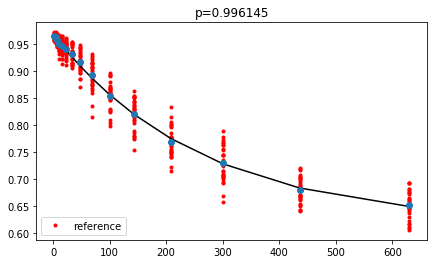

In [91]:
n, pop = n_RBw, pop_RBw
x = np.meshgrid(range(np.shape(pop)[1]),n)[1]
plt.figure(figsize=(7,4))
plt.plot(x.flatten(),pop.flatten(),'r.',label='reference')
plt.legend(loc='lower left')
x, y = n_RBw[:,0], np.abs(np.mean(pop,axis=1))
A,B,p = op.RB_Fit().fitRB(x,y)
z = A*p**x+B
plt.plot(x,z,'k')
plt.plot(x,y,'o')
plt.title('p=%f'%p)
plt.show()

## gate

In [366]:
mlist, q_target, len_data, which = np.logspace(0.4,2.8,16,dtype=int), q6, 30, measure.offwhich[0]
dragcoef = 0.8/q_target.alpha/2/np.pi

await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
for gate in ['2','3','4','5','6','7'][:1]:
    job = Job(mr.RB_waveform, (q_target,measure,mlist,len_data,which,110e6,dragcoef,gate), tags=[q_target.q_name,gate],no_bar=True)
    n_RBw, pop_RBw = await job.done()
await mr.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=[])

Output()

Output()

Output()

<IPython.core.display.Javascript object>


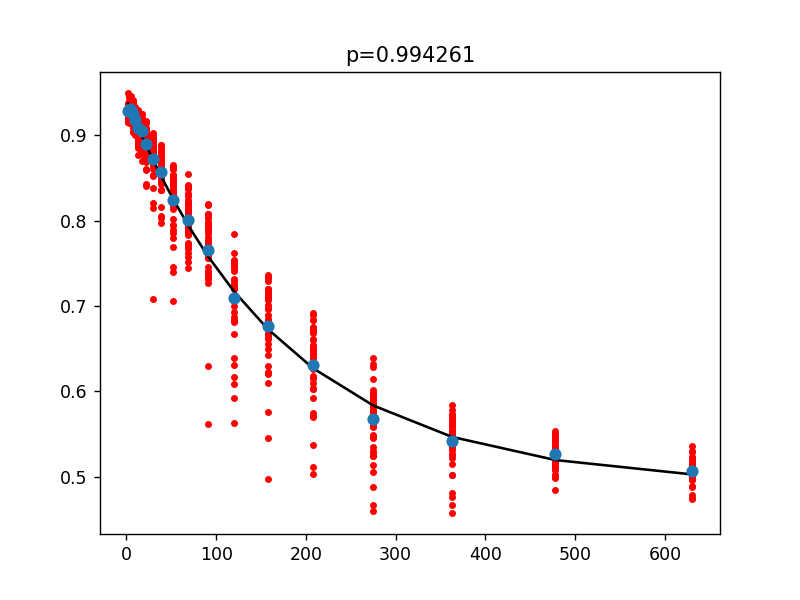

In [64]:
n, pop = n_RBw, pop_RBw
x = np.meshgrid(range(np.shape(pop)[1]),n)[1]
plt.figure(figsize=(7,4))
plt.plot(x.flatten(),pop.flatten(),'r.',label=gate)
plt.legend(loc='lower left')
x, y = n_RBw[:,0], np.abs(np.mean(pop,axis=1))
A,B,p = op.RB_Fit().fitRB(x,y)
z = A*p**x+B
plt.plot(x,z,'k')
plt.plot(x,y,'o')
plt.set_title('p=%f'%p)
plt.show()

In [70]:
Pref, Pgate, d = 0.9946, 0.994261, 2**(1)
Rgate = (1-Pgate/Pref)*(1-1/d)
Rgate

-0.003516601051131496

# 单比特tomo

In [551]:
q_target, which = q6, measure.onwhich
dragcoef = None
t_rabi = np.linspace(1,30,31)
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.tomo, (q_target,measure,t_rabi,which,dragcoef), tags=[q_target.q_name], max=len(t_rabi))
t_tomo, poplist = await job.done()

Output()

In [553]:
poplist

array([[0.4414557 , 0.68255538, 0.09434335],
       [0.44165348, 0.74643987, 0.14893196],
       [0.42464399, 0.84355222, 0.27650316],
       [0.44719146, 0.88627373, 0.40842563],
       [0.40051424, 0.89181171, 0.40150316],
       [0.38172468, 0.87440665, 0.58049842],
       [0.43908228, 0.7903481 , 0.7252769 ],
       [0.44481804, 0.71064082, 0.81863133],
       [0.38548259, 0.55439082, 0.89121835],
       [0.42780854, 0.42147943, 0.89339399],
       [0.47982595, 0.28322785, 0.84196994],
       [0.43413766, 0.17246835, 0.77907437],
       [0.45193829, 0.10324367, 0.65288766],
       [0.46677215, 0.05953323, 0.49545095],
       [0.45431171, 0.0820807 , 0.34572785],
       [0.47290348, 0.14102057, 0.23457278],
       [0.46756329, 0.23971519, 0.15268987],
       [0.47606804, 0.37321994, 0.0846519 ],
       [0.47448576, 0.51681171, 0.06784019],
       [0.45945411, 0.63073576, 0.09236551],
       [0.47883703, 0.75613133, 0.17780854],
       [0.47606804, 0.84177215, 0.28560127],
       [0.

In [554]:
data = [[1-2*j[i] for i in range(3)] for j in poplist]
data

[[0.11708860759493667, -0.3651107594936709, 0.8113132911392404],
 [0.11669303797468356, -0.4928797468354431, 0.7021360759493671],
 [0.15071202531645567, -0.6871044303797469, 0.446993670886076],
 [0.10561708860759489, -0.7725474683544304, 0.18314873417721522],
 [0.19897151898734178, -0.7836234177215189, 0.196993670886076],
 [0.23655063291139244, -0.7488132911392404, -0.160996835443038],
 [0.12183544303797467, -0.5806962025316456, -0.45055379746835444],
 [0.11036392405063289, -0.4212816455696202, -0.637262658227848],
 [0.22903481012658233, -0.10878164556962022, -0.7824367088607596],
 [0.1443829113924051, 0.15704113924050633, -0.7867879746835442],
 [0.04034810126582278, 0.43354430379746833, -0.6839398734177216],
 [0.13172468354430378, 0.6550632911392404, -0.5581487341772151],
 [0.096123417721519, 0.7935126582278481, -0.3057753164556962],
 [0.06645569620253167, 0.8809335443037974, 0.009098101265822778],
 [0.091376582278481, 0.8358386075949367, 0.30854430379746833],
 [0.054193037974683556, 

In [401]:
np.savez('z.npz',data=c)

In [284]:
x = [['I1','I2'],['Q1','Q2']]*2

In [288]:
[x[0]*2,x[1]*2]

[['I1', 'I2', 'I1', 'I2'], ['Q1', 'Q2', 'Q1', 'Q2']]

In [287]:
x

[['I1', 'I2'], ['Q1', 'Q2'], ['I1', 'I2'], ['Q1', 'Q2']]

In [270]:
import qulab.waveform_new as wn

In [276]:
cos = wn._basic_wave(wn.COS, 2*np.pi/10)
pulse = wn._add(wn._mul(cos, a), b)
pulse

((((), ()), (((4, 0, 0.6283185307179586),), (1,))), (0.54, 0.46))

In [275]:
a = wn._const(0.46)
b = wn._const(0.54)

In [286]:
t_lst = np.linspace(-90000,10000,250000)*1e-9
pulse = wn.hanning(10000/1e9)
wav = pulse(t_lst)

<IPython.core.display.Javascript object>


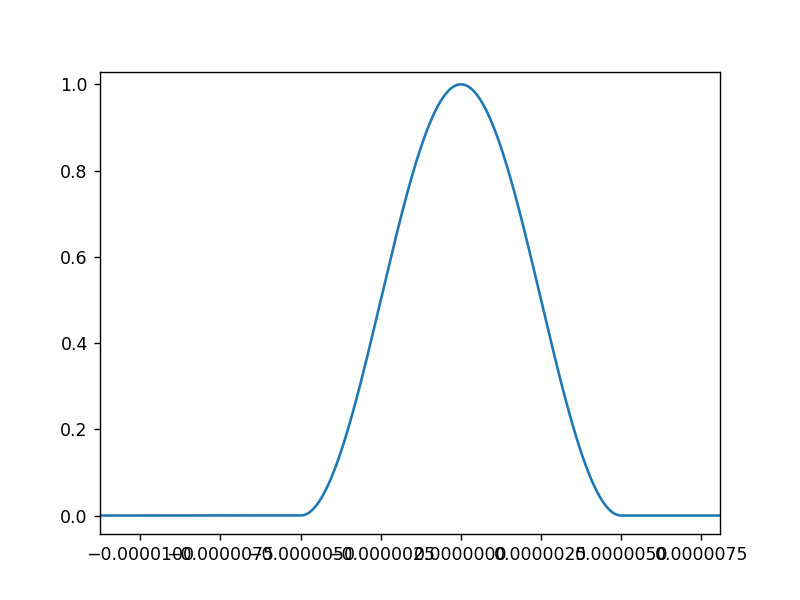

In [287]:
plt.figure()
plt.plot(t_lst,wav)